# The power of Hellmann-Feynman theorem: Kohn-Sham DFT energy derivatives with respect to the parameters of exchange-correlation functional at linear cost (supplementary material)
### Evgeny M. Kadilenko (ICKC SB RAS), Roland Grinis (MIPT, GrinisRIT)
#### Assistants: Gregory Dushkin (MIPT), Sabina Abdiganieva (MIPT)

### Preparing the globals

#### Imports

In [1]:
import dqc
import pyscf
from pyscf import gto, dft, scf, cc
import sympy
import inspect
import numpy
import torch
import xitorch as xt
from math import pi
import gc
import sys 
import time
import pandas as pd
from IPython.display import display, HTML, Math
import numba as nb
import matplotlib.pyplot as plt
from matplotlib import ticker
import functools
from ast import literal_eval
import copy

#### Software specifications:

In [2]:
print(f'PySCF version: {pyscf.__version__}')
print(f'DQC version: {dqc.__version__}')

PySCF version: 2.0.1
DQC version: 0.1.0


#### LDA and PBE constants:
We use two different *ab initio* functionals as an example.
The first one is LDA exchange:
$$
\epsilon \left[ \rho \right] = a \cdot \rho ^ p
$$
The second one is GGA-based PBE: [Perdew, J. P., Burke, K., & Ernzerhof, M. (1996). Generalized gradient approximation made simple. Physical review letters, 77(18), 3865.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.3865).

In [3]:
LDA_factor = -3.0/4.0 * (3.0 / pi)**(1.0/3.0)
LDA_power = 4.0/3.0
PW_a = 0.031091
PW_a_modified = 0.0310907
PW_alpha = 0.21370 
PW_beta1 = 7.5957 
PW_beta2 = 3.5876 
PW_beta3 = 1.6382 
PW_beta4 = 0.49294
PBE_kappa = 0.8040
PBE_mu = 0.2195149727645171
PBE_beta = 0.06672455060314922
PBE_gamma = (1 - numpy.log(2)) / pi ** 2

In [4]:
LDAX_default_parameters_dict = {'LDA_factor' : LDA_factor, 'LDA_power' : LDA_power}
PBE_default_parameters_dict = {'LDA_factor' : LDA_factor, 'LDA_power' : LDA_power,
                               'PBE_beta' : PBE_beta,     'PBE_gamma' : PBE_gamma,
                               'PBE_kappa' : PBE_kappa,   'PBE_mu' : PBE_mu, 
                               'PW_a' : PW_a_modified,    'PW_alpha' : PW_alpha, 
                               'PW_beta1' : PW_beta1,     'PW_beta2' : PW_beta2, 
                               'PW_beta3' : PW_beta3,     'PW_beta4' : PW_beta4}

### Correctness test: energy

#### Custom functionals

Here we take a look at the ways to implement an LDA and PBE functionals and compare them to some built-in methods.

In [5]:
class XCSympy():
    @staticmethod
    def init():
        XCSympy.rho = sympy.Symbol('rho', real=True)
        XCSympy.sigma = sympy.Symbol('sigma', real=True)
        
        XCSympy.LDA_factor = sympy.Symbol('LDA_factor', real=True)
        XCSympy.LDA_power  = sympy.Symbol('LDA_power', real=True)
        XCSympy.PBE_kappa  = sympy.Symbol('PBE_kappa', real=True)
        XCSympy.PBE_mu     = sympy.Symbol('PBE_mu', real=True)
        XCSympy.PW_a       = sympy.Symbol('PW_a', real=True)
        XCSympy.PW_alpha   = sympy.Symbol('PW_alpha', real=True)
        XCSympy.PW_beta1   = sympy.Symbol('PW_beta1', real=True)
        XCSympy.PW_beta2   = sympy.Symbol('PW_beta2', real=True)
        XCSympy.PW_beta3   = sympy.Symbol('PW_beta3', real=True)
        XCSympy.PW_beta4   = sympy.Symbol('PW_beta4', real=True)
        XCSympy.PBE_beta   = sympy.Symbol('PBE_beta', real=True)
        XCSympy.PBE_gamma  = sympy.Symbol('PBE_gamma', real=True)
        
        XCSympy.ex_lda_sympy = XCSympy.LDA_factor * XCSympy.rho ** (XCSympy.LDA_power - 1)
        
        rs = XCSympy.rho ** (-1 / 3) * (3 / (4 * pi)) ** (1 / 3)
        g_aux = XCSympy.PW_beta1 * rs ** (1 / 2) + XCSympy.PW_beta2 * rs + XCSympy.PW_beta3 * rs ** (3 / 2) + XCSympy.PW_beta4 * rs ** 2
        XCSympy.ec_pw_sympy = -2 * XCSympy.PW_a * (1 + XCSympy.PW_alpha * rs) * sympy.log(1 + 1/(2 * XCSympy.PW_a * g_aux))

        s = XCSympy.sigma ** 0.5 / (2 * (3 * pi ** 2) ** (1 / 3) * XCSympy.rho ** (4 / 3))
        pbe_x_factor_sympy = 1 + XCSympy.PBE_kappa - XCSympy.PBE_kappa ** 2 / (XCSympy.PBE_kappa + XCSympy.PBE_mu * s ** 2)
        XCSympy.ex_pbe_sympy = XCSympy.ex_lda_sympy * pbe_x_factor_sympy
        
        t = XCSympy.sigma ** 0.5 * (pi / 3) ** (1 / 6) / (4 * XCSympy.rho ** (7 / 6))
        A = XCSympy.PBE_beta / (XCSympy.PBE_gamma * (sympy.exp(-XCSympy.ec_pw_sympy / XCSympy.PBE_gamma) - 1))
        f1 = t ** 2 + A * t ** 4
        f2 = XCSympy.PBE_beta * f1 / (XCSympy.PBE_gamma * (1 + A * f1))
        fH = XCSympy.PBE_gamma * sympy.log(1 + f2)
        XCSympy.ec_pbe_sympy = XCSympy.ec_pw_sympy + fH
        
        XCSympy.exc_pbe_sympy = XCSympy.ec_pbe_sympy + XCSympy.ex_pbe_sympy

    @staticmethod
    def subs(expression, params):
        for key, value in params.items():
            expression = expression.subs(XCSympy.__getattribute__(XCSympy, key), value)
        return expression
    
XCSympy.init()

#### PySCF

PySCF accepts custom functionals as Python functions

In [6]:
class PySCFLDAXConstructor():
    @staticmethod
    def parse_data(data):
        if torch.is_tensor(data):
            torch.nan_to_num(data)
        else:
            numpy.nan_to_num(data) # delete NaNs
        data.clip(0) # delete negative numbers
        data += 1e-15
        
        return data

    def __init__(self, params):
        self.family = "LDA"
        self.params = params

        ex_lda_sympy = XCSympy.subs(XCSympy.ex_lda_sympy, self.params)
    
        dexlda_wrt_drho_sympy = sympy.diff(ex_lda_sympy, XCSympy.rho)
    
        ex_lda_numpy = sympy.lambdify((XCSympy.rho), ex_lda_sympy, "numpy", cse=True)
        ex_lda_torch = sympy.lambdify((XCSympy.rho), ex_lda_sympy, 
                                      modules={'log': torch.log, 'exp': torch.exp}, cse=True)
        dexlda_wrt_drho_numpy = sympy.lambdify((XCSympy.rho), dexlda_wrt_drho_sympy, "numpy", cse=True)
        dexlda_wrt_drho_torch = sympy.lambdify((XCSympy.rho), dexlda_wrt_drho_sympy, 
                                               modules={'log': torch.log, 'exp': torch.exp}, cse=True)

        def eval_xc(xc_code, data, *args, **kwargs):
            rho = PySCFLDAXConstructor.parse_data(data)
            if torch.is_tensor(rho):
                ex_lda = ex_lda_torch(rho)
                dexlda_wrt_drho = dexlda_wrt_drho_torch(rho)
            else:
                ex_lda = ex_lda_numpy(rho)
                dexlda_wrt_drho = dexlda_wrt_drho_numpy(rho)
            vrho_lda = ex_lda + rho * dexlda_wrt_drho

            vxc_lda = (vrho_lda, None, None, None)
            return ex_lda, vxc_lda, None, None
        self.eval_xc = eval_xc
        
        d2exc_wrt_drho2_sympy = sympy.diff(dexlda_wrt_drho_sympy, XCSympy.rho)
        d2exc_wrt_drho2_numpy = sympy.lambdify((XCSympy.rho), d2exc_wrt_drho2_sympy, "numpy", cse=True)

        def eval_dvxc_wrt_drho(data, *args, **kwargs):
            rho = PySCFLDAXConstructor.parse_data(data)
            dexlda_wrt_drho = dexlda_wrt_drho_numpy(rho)
            d2exc_wrt_drho2 = d2exc_wrt_drho2_numpy(rho)
            
            return 2 * dexlda_wrt_drho + rho * d2exc_wrt_drho2
        self.eval_dvxc_wrt_drho = eval_dvxc_wrt_drho

    @staticmethod
    def decorate_cache_rho_on_grid(qc):
        qc.grids.build(with_non0tab=True)
        qc.grids.rho = numpy.empty((qc.grids.coords.shape[0],))
        qc.grids.number_of_written_rho_values = 0

        def cached_gen_rho_evaluator(*args, **kargs):
            make_rho_clear, ndms, nao = dft.numint.NumInt()._gen_rho_evaluator(*args, **kargs)
            def make_rho_cached(idm, ao, sindex, xctype):
                rho = make_rho_clear(idm, ao, sindex, xctype)

                if qc.grids.number_of_written_rho_values == qc.grids.rho.shape[0]:
                    qc.grids.rho = numpy.empty((qc.grids.coords.shape[0],))
                    qc.grids.number_of_written_rho_values = 0

                n = qc.grids.number_of_written_rho_values
                qc.grids.rho[n:n+rho.shape[0]] = rho
                qc.grids.number_of_written_rho_values += rho.shape[0]

                return rho
            return make_rho_cached, ndms, nao

        qc._numint._gen_rho_evaluator = cached_gen_rho_evaluator
    
    def construct_derivarives_calculator(self):
        self.names = self.params.keys()
        
        ex_lda_derivative_sympy_list = []
        vx_lda_derivative_sympy_list = []
        
        for key in self.params.keys():
            ex_lda_derivative_sympy = sympy.diff(XCSympy.ex_lda_sympy, XCSympy.__getattribute__(XCSympy, key))
            ex_lda_derivative_sympy = XCSympy.rho * XCSympy.subs(ex_lda_derivative_sympy, self.params)
            ex_lda_derivative_sympy_list.append(ex_lda_derivative_sympy)
            
            vx_lda_derivative_sympy = sympy.diff(ex_lda_derivative_sympy, XCSympy.rho)
            vx_lda_derivative_sympy_list.append(vx_lda_derivative_sympy)
        
        ex_lda_derivative_sympy_list = sympy.Array(ex_lda_derivative_sympy_list)
        ex_lda_derivative_numpy_list = sympy.lambdify((XCSympy.rho), ex_lda_derivative_sympy_list, 
                                                      modules=[{'exp': numpy.exp, 
                                                                'log': numpy.log}], cse=True)
        ex_lda_derivative_numpy_list = nb.njit(ex_lda_derivative_numpy_list)
                
        self.derivatives_calculator = ex_lda_derivative_numpy_list
        
        vx_lda_derivative_sympy_list = sympy.Array(vx_lda_derivative_sympy_list)
        vx_lda_derivative_numpy_list = sympy.lambdify((XCSympy.rho), vx_lda_derivative_sympy_list, 
                                                      modules=[{'exp': numpy.exp, 
                                                                'log': numpy.log}], cse=True)
        vx_lda_derivative_numpy_list = nb.njit(vx_lda_derivative_numpy_list)
                
        self.derivatives_calculator_vx = vx_lda_derivative_numpy_list

    
    def calculate_derivatives(self, data):
        rho = PySCFLDAXConstructor.parse_data(data)
        return numpy.stack(self.derivatives_calculator(rho))
    
    def calculate_vxc_derivatives(self, data):
        rho = PySCFLDAXConstructor.parse_data(data)
        return numpy.stack(self.derivatives_calculator_vx(rho))

In [7]:
class PySCFPBEConstructor():
    @staticmethod
    def parse_data(data):
        if type(data) is tuple:
            rho = data[0]
            dx, dy, dz = data[1]
        else:
            rho, dx, dy, dz = data[:4]

        if torch.is_tensor(rho):
            torch.nan_to_num(rho)
        else:
            numpy.nan_to_num(rho) # delete NaNs
        rho.clip(0) # delete negative numbers
        rho += 1e-15

        sigma = dx**2 + dy**2 + dz**2
        
        return rho, sigma, (dx, dy, dz)

    def __init__(self, params):
        self.family = "GGA"
        self.params = params

        exc_pbe_sympy = XCSympy.subs(XCSympy.exc_pbe_sympy, self.params)

        dexcpbe_wrt_drho_sympy = sympy.diff(exc_pbe_sympy, XCSympy.rho)
        dexcpbe_wrt_dsigma_sympy = sympy.diff(exc_pbe_sympy, XCSympy.sigma)

        exc_pbe_numpy = sympy.lambdify((XCSympy.rho, XCSympy.sigma), exc_pbe_sympy, "numpy", cse=True)
        dexcpbe_wrt_drho_numpy = sympy.lambdify((XCSympy.rho, XCSympy.sigma), dexcpbe_wrt_drho_sympy, "numpy", cse=True)
        dexcpbe_wrt_dsigma_numpy = sympy.lambdify((XCSympy.rho, XCSympy.sigma), dexcpbe_wrt_dsigma_sympy, "numpy", cse=True)

        exc_pbe_torch = sympy.lambdify((XCSympy.rho, XCSympy.sigma), exc_pbe_sympy, 
                                       modules={'log': torch.log, 'exp': torch.exp}, cse=True)
        dexcpbe_wrt_drho_torch = sympy.lambdify((XCSympy.rho, XCSympy.sigma), dexcpbe_wrt_drho_sympy, 
                                                modules={'log': torch.log, 'exp': torch.exp}, cse=True)
        dexcpbe_wrt_dsigma_torch = sympy.lambdify((XCSympy.rho, XCSympy.sigma), dexcpbe_wrt_dsigma_sympy, 
                                                  modules={'log': torch.log, 'exp': torch.exp}, cse=True)

        
        def eval_xc(xc_code, data, *args, **kwargs):
            rho, sigma, _ = PySCFPBEConstructor.parse_data(data)

            if torch.is_tensor(rho):
                exc_pbe = exc_pbe_torch(rho, sigma)

                dexcpbe_wrt_drho = dexcpbe_wrt_drho_torch(rho, sigma)
                dexcpbe_wrt_dsigma = dexcpbe_wrt_dsigma_torch(rho, sigma)
            else:
                exc_pbe = exc_pbe_numpy(rho, sigma)

                dexcpbe_wrt_drho = dexcpbe_wrt_drho_numpy(rho, sigma)
                dexcpbe_wrt_dsigma = dexcpbe_wrt_dsigma_numpy(rho, sigma)

            vrho_pbe = exc_pbe + rho * dexcpbe_wrt_drho
            vsigma_pbe = rho * dexcpbe_wrt_dsigma

            vxc_pbe = (vrho_pbe, vsigma_pbe, None, None)
            return exc_pbe, vxc_pbe, None, None
        self.eval_xc = eval_xc

    @staticmethod
    def decorate_cache_rho_on_grid(qc):
        qc.grids.build(with_non0tab=True)
        qc.grids.rho = numpy.empty((4, qc.grids.coords.shape[0]))
        qc.grids.number_of_written_rho_values = 0

        def cached_gen_rho_evaluator(*args, **kargs):
            make_rho_clear, ndms, nao = dft.numint.NumInt()._gen_rho_evaluator(*args, **kargs)
            def make_rho_cached(idm, ao, sindex, xctype):
                rho = make_rho_clear(idm, ao, sindex, xctype)

                if qc.grids.number_of_written_rho_values == qc.grids.rho.shape[1]:
                    qc.grids.rho = numpy.empty((4, qc.grids.coords.shape[0]))
                    qc.grids.number_of_written_rho_values = 0

                n = qc.grids.number_of_written_rho_values
                qc.grids.rho[:, n:n+rho.shape[1]] = rho
                qc.grids.number_of_written_rho_values += rho.shape[1]

                return rho
            return make_rho_cached, ndms, nao

        qc._numint._gen_rho_evaluator = cached_gen_rho_evaluator
    
    def construct_derivarives_calculator(self):
        self.names = self.params.keys()
        
        exc_pbe_derivative_sympy_list = []
        vxc_pbe_derivative_rho_sympy_list = []
        vxc_pbe_derivative_sigma_sympy_list = []
        
        for key in self.params.keys():
            exc_pbe_derivative_sympy = sympy.diff(XCSympy.exc_pbe_sympy, XCSympy.__getattribute__(XCSympy, key))
            exc_pbe_derivative_sympy = XCSympy.rho * XCSympy.subs(exc_pbe_derivative_sympy, self.params)
            exc_pbe_derivative_sympy_list.append(exc_pbe_derivative_sympy)
            
            vxc_pbe_derivative_rho_sympy = sympy.diff(exc_pbe_derivative_sympy, XCSympy.rho)
            vxc_pbe_derivative_rho_sympy_list.append(vxc_pbe_derivative_rho_sympy)
            vxc_pbe_derivative_sigma_sympy = sympy.diff(exc_pbe_derivative_sympy, XCSympy.sigma)
            vxc_pbe_derivative_sigma_sympy_list.append(vxc_pbe_derivative_sigma_sympy)

        exc_pbe_derivative_sympy_list = sympy.Array(exc_pbe_derivative_sympy_list)
        exc_pbe_derivative_numpy_list = sympy.lambdify((XCSympy.rho, XCSympy.sigma), exc_pbe_derivative_sympy_list, 
                                                       modules=[{'exp': numpy.exp, 
                                                                 'log': numpy.log}], cse=True)
        
        self.derivatives_calculator = nb.njit(exc_pbe_derivative_numpy_list)
        
        vxc_pbe_derivative_rho_sympy_list = sympy.Array(vxc_pbe_derivative_rho_sympy_list)
        vxc_pbe_derivative_rho_numpy_list = sympy.lambdify((XCSympy.rho, XCSympy.sigma), 
                                                           vxc_pbe_derivative_rho_sympy_list, 
                                                      modules=[{'exp': numpy.exp, 
                                                                'log': numpy.log}], cse=True)
        vxc_pbe_derivative_rho_numpy_list = nb.njit(vxc_pbe_derivative_rho_numpy_list)
                
        self.derivatives_calculator_vxc_rho = vxc_pbe_derivative_rho_numpy_list
        
        vxc_pbe_derivative_sigma_sympy_list = sympy.Array(vxc_pbe_derivative_sigma_sympy_list)
        vxc_pbe_derivative_sigma_numpy_list = sympy.lambdify((XCSympy.rho, XCSympy.sigma), 
                                                           vxc_pbe_derivative_sigma_sympy_list, 
                                                      modules=[{'exp': numpy.exp, 
                                                                'log': numpy.log}], cse=True)
        vxc_pbe_derivative_sigma_numpy_list = nb.njit(vxc_pbe_derivative_sigma_numpy_list)
                
        self.derivatives_calculator_vxc_sigma = vxc_pbe_derivative_sigma_numpy_list


    def calculate_derivatives(self, data):
        rho, sigma, _ = PySCFPBEConstructor.parse_data(data)
        return numpy.stack(self.derivatives_calculator(rho, sigma))

    def calculate_vxc_derivatives(self, data):
        rho, sigma, gradient = PySCFPBEConstructor.parse_data(data)
        gradient = numpy.stack(gradient)
        vxc_pbe_derivative_rho = numpy.stack(self.derivatives_calculator_vxc_rho(rho, sigma))
        vxc_pbe_derivative_sigma = numpy.stack(self.derivatives_calculator_vxc_sigma(rho, sigma))
        vxc_pbe_derivative_gradient = 2 * numpy.einsum("pg,xg->pxg", vxc_pbe_derivative_sigma, gradient)
        return (vxc_pbe_derivative_rho, vxc_pbe_derivative_gradient)

In [8]:
class PySCFAdapterCustom():
    def __init__(self, XCConstructor, params, mol, basis="6-31G"):
        self.scf_mol = gto.M(atom=mol, basis=basis, unit="Bohr", verbose=0)
    
        # Timer
        start = time.time()
        self.qc = dft.RKS(self.scf_mol)
        self.xc = XCConstructor(params)
        self.qc = self.qc.define_xc_(self.xc.eval_xc, self.xc.family)
        
        self.total_energy = self.qc.kernel()
        self.duration = time.time() - start
        self.converged = self.qc.converged
        
    def construct_rho_squared(self, rho_exact):
        dm = self.qc.make_rdm1()        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, self.qc.grids.coords, deriv=0)
        rho_on_grid = pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm, xctype='LDA')
    
        diff_squared = (rho_on_grid - rho_exact) ** 2
        self.rho_squared = (self.qc.grids.weights @ diff_squared)

    def construct_rho_on_grid(self, grid):
        dm_ao = self.qc.make_rdm1(ao_repr=True)

        if hasattr(grid, "numpy"):
            grid = grid.numpy()
        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, grid, deriv=0)
        return pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm_ao, xctype='LDA')

# To compare the results, we would use PySCF's built-in implementation of the same functional
class PySCFAdapterBuiltin():
    def __init__(self, xc_name, mol, basis="6-31G"):
        self.scf_mol = gto.M(atom=mol, basis=basis, unit="Bohr", verbose=0)
        
        # Timer
        start = time.time()
        self.qc = dft.RKS(self.scf_mol)
        self.qc.xc = xc_name # Built-in functional implementation
        
        self.total_energy = self.qc.kernel()
        self.duration = time.time() - start
        self.converged = self.qc.converged
        
    def construct_rho_squared(self, rho_exact):
        dm = self.qc.make_rdm1()        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, self.qc.grids.coords, deriv=0)
        rho_on_grid = pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm, xctype='LDA')
    
        diff_squared = (rho_on_grid - rho_exact) ** 2
        self.rho_squared = (self.qc.grids.weights @ diff_squared)

    def construct_rho_on_grid(self, grid):
        dm_ao = self.qc.make_rdm1(ao_repr=True)

        if hasattr(grid, "numpy"):
            grid = grid.numpy()
        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, grid, deriv=0)
        return pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm_ao, xctype='LDA')

class PySCFAdapterAuto():
    def __init__(self, XCConstructor, params, mol, basis="6-31G", decorator=True):
        self.scf_mol = gto.M(atom=mol, basis=basis, unit="Bohr", verbose=0)
        
        # Timer        
        start = time.time()
        self.qc = dft.RKS(self.scf_mol)
        self.xc = XCConstructor(params)
        if (XCConstructor == PySCFLDAXConstructor) and (params == LDAX_default_parameters_dict):
            self.qc.xc = "lda," # Built-in functional implementation
        elif (XCConstructor == PySCFPBEConstructor) and (params == PBE_default_parameters_dict):
            self.qc.xc = "pbe,pbe" # Built-in functional implementation
        else:
            self.qc = self.qc.define_xc_(self.xc.eval_xc, self.xc.family)
            
        if decorator:
            XCConstructor.decorate_cache_rho_on_grid(self.qc)
        
        self.total_energy = self.qc.kernel()
        self.duration = time.time() - start
        self.converged = self.qc.converged

    def construct_rho_squared(self, rho_exact):
        dm = self.qc.make_rdm1()        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, self.qc.grids.coords, deriv=0)
        rho_on_grid = pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm, xctype='LDA')
    
        diff_squared = (rho_on_grid - rho_exact) ** 2
        self.rho_squared = (self.qc.grids.weights @ diff_squared)

    def construct_rho_on_grid(self, grid):
        dm_ao = self.qc.make_rdm1(ao_repr=True)

        if hasattr(grid, "numpy"):
            grid = grid.numpy()
        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, grid, deriv=0)
        return pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm_ao, xctype='LDA')
        
# CCSD(T)
class PySCFAdapterCCSDT():
    def __init__(self, mol, basis="6-31G"):
        self.scf_mol = gto.M(atom=mol, basis=basis, unit="Bohr", verbose=0)
        
        start = time.time()
        hf_ = scf.HF(self.scf_mol)

        hf = hf_.run()
        self.qc = cc.CCSD(hf)
        ccsd_energy = self.qc.kernel()
        triples_energy = self.qc.ccsd_t()
        self.total_energy = self.qc.e_tot + triples_energy
        self.duration = time.time() - start
        self.converged = self.qc.converged
        
    def construct_rho_on_grid(self, grid):
        dm_ao = self.qc.make_rdm1(ao_repr=True)

        if hasattr(grid, "numpy"):
            grid = grid.numpy()
        
        ao_value = pyscf.dft.numint.eval_ao(self.scf_mol, grid, deriv=0)
        return pyscf.dft.numint.eval_rho(self.scf_mol, ao_value, dm_ao, xctype='LDA')

#### DQC

DQC accepts custom functionals as objects of classes derived from `dqc.xc.CustomXC`

In [9]:
class DQCLDAXConstructor(dqc.xc.CustomXC):
    def __init__(self, params):
        super().__init__()
        self.number_of_parameters = len(params)
        self.params = params

        self.params_sympy = [XCSympy.__getattribute__(XCSympy, param_name) for param_name in params.keys()]
        
        ex_lda_sympy = XCSympy.rho * XCSympy.ex_lda_sympy
    
        self.ex_lda_torch = sympy.lambdify((XCSympy.rho, *self.params_sympy), 
                                           ex_lda_sympy, modules={'log': torch.log, 'exp': torch.exp}, cse=True)
        
    @property
    def family(self):
        # 1 for LDA, 2 for GGA, 4 for MGGA
        return 1

    def get_edensityxc(self, densinfo):
        # densinfo has up and down components
        if isinstance(densinfo, dqc.utils.SpinParam):
            raise NotImplementedError("polarized case is not implemented")
        else:
            rho = densinfo.value.abs() + 1e-15  # safeguarding from nan
            return self.ex_lda_torch(rho, *self.params.values())

    def get_edensityxc_derivative(self, densinfo, number_of_parameter):
        def derivative_calculator(ex_lda_sympy, symbol):
            derivative_sympy = sympy.diff(ex_lda_sympy, symbol)
            derivative_torch = sympy.lambdify((XCSympy.rho, *self.params_sympy), 
                                              derivative_sympy, 
                                              modules={'log': torch.log, 'exp': torch.exp}, cse=True)
            return derivative_torch(rho, *self.params.values())

        # densinfo has up and down components
        if isinstance(densinfo, dqc.utils.SpinParam):
            # spin-scaling of the exchange energy
            raise NotImplementedError("polarized case is not implemented")
        else:
            rho = densinfo.value.abs() + 1e-15  # safeguarding from nan
            ex_lda_sympy = XCSympy.rho * XCSympy.ex_lda_sympy
            return derivative_calculator(ex_lda_sympy, self.params_sympy[number_of_parameter])

In [10]:
class DQCPBEConstructor(dqc.xc.CustomXC):
    def __init__(self, params):
        super().__init__()
        
        self.number_of_parameters = len(params)
        self.params = params

        self.params_sympy = [XCSympy.__getattribute__(XCSympy, param_name) for param_name in params.keys()]
        
        exc_pbe_sympy = XCSympy.rho * XCSympy.exc_pbe_sympy
                
        self.exc_pbe_torch = sympy.lambdify((XCSympy.rho, XCSympy.sigma, *self.params_sympy), exc_pbe_sympy, 
                                            modules={'log': torch.log, 'exp': torch.exp}, cse=True)

    @property
    def family(self):
        # 1 for LDA, 2 for GGA, 4 for MGGA
        return 2

    def get_edensityxc(self, densinfo):
        # densinfo has up and down components
        if isinstance(densinfo, dqc.utils.SpinParam):
            raise NotImplementedError("polarized case is not implemented")
        else:
            rho = densinfo.value.abs() + 1e-15  # safeguarding from nan
            sigma = densinfo.grad[0]**2 + densinfo.grad[1]**2 + densinfo.grad[2]**2 + 1e-15  # safeguarding from nan
            
            return self.exc_pbe_torch(rho, sigma, *self.params.values())

    def get_edensityxc_derivative(self, densinfo, number_of_parameter):
        def derivative_calculator(exc_pbe_sympy, symbol):
            derivative_sympy = sympy.diff(exc_pbe_sympy, symbol)
            derivative_torch = sympy.lambdify((XCSympy.rho, XCSympy.sigma, *self.params_sympy), 
                                              derivative_sympy, 
                                              modules={'log': torch.log, 'exp': torch.exp}, cse=True)
            return derivative_torch(rho, sigma, *self.params.values())

        # densinfo has up and down components
        if isinstance(densinfo, dqc.utils.SpinParam):
            raise NotImplementedError("polarized case is not implemented")
        else:
            rho = densinfo.value.abs() + 1e-15  # safeguarding from nan
            sigma = densinfo.grad[0]**2 + densinfo.grad[1]**2 + densinfo.grad[2]**2 + 1e-15  # safeguarding from nan
            exc_pbe_sympy = XCSympy.rho * XCSympy.exc_pbe_sympy
            return derivative_calculator(exc_pbe_sympy, self.params_sympy[number_of_parameter])

In [11]:
class DQCAdapterWithgrad():
    def __init__(self, XCConstructor, params, mol, basis="6-31G"):
        atmozs, atomposs = dqc.parse_moldesc(mol)
        dqc_mol = dqc.Mol((atmozs, atomposs), basis=basis)

        start = time.time()
        self.params = torch.nn.ParameterDict({k : torch.nn.Parameter(torch.tensor(v, dtype=torch.double)) for k, v in params.items()})
        self.qc = dqc.KS(dqc_mol, xc=XCConstructor(self.params)).run()

        self.total_energy = self.qc.energy()
        self.converged = True
        self.duration = time.time() - start
    
    def construct_rho_squared(self, rho_exact):
        densinfo = SpinParam.apply_fcn(lambda dm_: self.qc.get_system().get_hamiltonian()._dm2densinfo(dm_), 
                                    self.qc._dm).value
        diff_squared = (densinfo - torch.from_numpy(rho_exact)).pow(2)
        self.rho_squared = self.qc.get_system().get_hamiltonian().dvolume @ diff_squared
        self.rho_squared.requires_grad_()
        
class DQCAdapterNograd():
    def __init__(self, XCConstructor, params, mol, basis="6-31G"):
        with torch.no_grad():
            atmozs, atomposs = dqc.parse_moldesc(mol)
            dqc_mol = dqc.Mol((atmozs, atomposs), basis=basis)

            start = time.time()
            self.params = torch.nn.ParameterDict({k : torch.nn.Parameter(torch.tensor(v, dtype=torch.double)) for k, v in params.items()})
            self.qc = dqc.KS(dqc_mol, xc=XCConstructor(self.params)).run()
            
            self.total_energy = self.qc.energy().numpy()
            self.converged = True
            self.duration = time.time() - start
            
    def construct_rho_squared(self, rho_exact):
        with torch.no_grad():
            densinfo = SpinParam.apply_fcn(lambda dm_: self.qc.get_system().get_hamiltonian()._dm2densinfo(dm_), 
                                        self.qc._dm).value
            diff_squared = (densinfo - rho_exact).pow(2)
            self.rho_squared = (self.qc.get_system().get_hamiltonian().dvolume @ diff_squared).numpy()

#### Comparison test

Let's compare all of the above methods (also, for convenience, all of the results are compiled at the end of the notebook in tables).

In [12]:
molecules_for_correctness_tests = {
    "h2"       :  """
                  H 0 0 0; H 1.4 0 0
                  """
    ,
    "water"    : """
                 O        0.000000000      0.000000000      0.000000000;
                 H        0.000000000      1.434938863      1.126357947;
                 H        0.000000000     -1.434938863      1.12635794
                 """
     ,
    "ethane": """
                 C       -0.570532088      0.000000000     -0.925021293;
                 H       -0.570532088      1.019690000     -1.324277293;
                 H        0.312545912     -0.509845000     -1.324277293;
                 H       -1.453610088     -0.509845000     -1.324277293;
                 C       -0.570532088      0.000000000      0.604966707;
                 H       -1.453610088      0.509845000      1.004222707;
                 H       -0.570532088     -1.019690000      1.004222707;
                 H        0.312545912      0.509845000      1.004222707
              """
    ,
    "benzene" : """
                C        0.598362921      0.000000000     -4.742986733;
                C       -0.557705772     -0.354690359     -4.044822733;
                C        1.754431614      0.354690359     -4.044822733;
                H       -1.457130878     -0.630640582     -4.587995733;
                H        2.653856720      0.630640582     -4.587995733;
                C       -0.557705772     -0.354690359     -2.648492733;
                C        1.754431614      0.354690359     -2.648492733;
                H       -1.457130878     -0.630640582     -2.105319733;
                H        2.653856720      0.630640582     -2.105319733;
                C        0.598362921      0.000000000     -1.950328733;
                H        0.598362921      0.000000000     -0.863981733;
                H        0.598362921      0.000000000     -5.829333733
                """
}

In [13]:
energy_correctness_results = {
    "pyscf_builtin_lda":    {},
    "pyscf_custom_lda":     {},
    "pyscf_builtin_pbe":    {},
    "pyscf_custom_pbe":     {},
    "pyscf_ccsdt":      {},
    "dqc_nograd_lda":       {},
    "dqc_nograd_pbe":       {},
}

for data_of_method in energy_correctness_results.values():
    for mol_name in molecules_for_correctness_tests:
        data_of_method[mol_name] = {}

In [14]:
def print_results_energy(mol_name, method_name, e, c, d):
    print(f"For {mol_name} molecule and {method_name} method: energy={e} Eh, duration={d} s")
    if not c:
        print(f"Calculation for {mol_name} and method {method_name} did not converge", file=sys.stderr)

def print_and_save_results_energy(mol_name, method_name, e, c, d):
    print_results_energy(mol_name, method_name, e, c, d)
    energy_correctness_results[method_name][mol_name]["energy"] = e
    energy_correctness_results[method_name][mol_name]["converged"] = c
    energy_correctness_results[method_name][mol_name]["time"] = d

for mol_name, mol in molecules_for_correctness_tests.items():
    calc = PySCFAdapterCCSDT(mol)
    print_and_save_results_energy(mol_name, "pyscf_ccsdt", calc.total_energy, calc.converged, calc.duration)
    
    calc = PySCFAdapterBuiltin("lda,", mol)
    print_and_save_results_energy(mol_name, "pyscf_builtin_lda", calc.total_energy, calc.converged, calc.duration)

    calc = PySCFAdapterCustom(PySCFLDAXConstructor, LDAX_default_parameters_dict, mol)
    print_and_save_results_energy(mol_name, "pyscf_custom_lda", calc.total_energy, calc.converged, calc.duration)

    calc = DQCAdapterNograd(DQCLDAXConstructor, LDAX_default_parameters_dict, mol)
    print_and_save_results_energy(mol_name, "dqc_nograd_lda", calc.total_energy, calc.converged, calc.duration)
    
    calc = PySCFAdapterBuiltin("pbe,pbe", mol)
    print_and_save_results_energy(mol_name, "pyscf_builtin_pbe", calc.total_energy, calc.converged, calc.duration)

    calc = PySCFAdapterCustom(PySCFPBEConstructor, PBE_default_parameters_dict, mol)
    print_and_save_results_energy(mol_name, "pyscf_custom_pbe", calc.total_energy, calc.converged, calc.duration)
        
    calc = DQCAdapterNograd(DQCPBEConstructor, PBE_default_parameters_dict, mol)
    print_and_save_results_energy(mol_name, "dqc_nograd_pbe", calc.total_energy, calc.converged, calc.duration)
    
    print("---><---")

For h2 molecule and pyscf_ccsdt method: energy=-1.1516791660767651 Eh, duration=0.0632789134979248 s
For h2 molecule and pyscf_builtin_lda method: energy=-1.0386177856738823 Eh, duration=0.25028014183044434 s
For h2 molecule and pyscf_custom_lda method: energy=-1.0386177856739316 Eh, duration=0.28223514556884766 s
For h2 molecule and dqc_nograd_lda method: energy=-1.0386170699228439 Eh, duration=0.06942272186279297 s
For h2 molecule and pyscf_builtin_pbe method: energy=-1.1619157577671002 Eh, duration=0.06540799140930176 s
For h2 molecule and pyscf_custom_pbe method: energy=-1.1619157577671704 Eh, duration=0.769817590713501 s
For h2 molecule and dqc_nograd_pbe method: energy=-1.1619148796560532 Eh, duration=0.23385310173034668 s
---><---
For water molecule and pyscf_ccsdt method: energy=-76.12064120720736 Eh, duration=0.09794378280639648 s
For water molecule and pyscf_builtin_lda method: energy=-75.15470534025631 Eh, duration=0.3606703281402588 s
For water molecule and pyscf_custom_lda

The results of calculations with custom LDA functionals are in excellent agreement with the results of calculations with builtin LDA functional.

### Existing methods for calculation of energy derivatives.

The basic way to compute energy derivatives is to use finite differences. DQC also allows to make use of PyTorch's `autograd`. We will also explore the implicit differentiation method.

From now on, all of the calculations will rely on user defined functionals.

### Finite differences

Calculating derivatives via finite difference is straighforward once there is a way to calculate energy:

In [15]:
def FiniteDifferenceTotalDerivativeCalculator(adapter_class, XCConstructor, params, getter, mol, 
                                              bump_factor=0.00001, basis="6-31G"):
    c = True
    total_duration = 0
    
#     calc = adapter_class(XCConstructor, params, mol, basis=basis)
#     value = getter(calc)
#     total_duration += calc.duration
#     c &= calc.converged
    
    derivatives = {}
    
    for key, param in params.items():
        params_shifted_plus = copy.deepcopy(params)
        params_shifted_minus = copy.deepcopy(params)

        param_shifted = param * bump_factor
        params_shifted_plus[key] += param_shifted
        params_shifted_minus[key] -= param_shifted
        
        calc_shifted_plus = adapter_class(XCConstructor, params_shifted_plus, mol, basis=basis)
        total_duration += calc_shifted_plus.duration
        c &= calc_shifted_plus.converged
        
        calc_shifted_minus = adapter_class(XCConstructor, params_shifted_minus, mol, basis=basis)
        total_duration += calc_shifted_minus.duration
        c &= calc_shifted_minus.converged
        
        value_shifted_plus = getter(calc_shifted_plus)
        value_shifted_minus = getter(calc_shifted_minus)
        derivative = (value_shifted_plus - value_shifted_minus) / (2 * param_shifted)
        
        derivatives[key] = derivative

    if not c:
        print(f"One of finite difference computations for {mol} didn't converge with {method}", file=sys.stderr)

    return numpy.stack(list(derivatives.values())), total_duration, c

### Iterative `torch.autograd`

In [16]:
class IterativeAutogradTotalDerivativeCalculator():
    def __init__(self, adapter):
        self.adapter = adapter
    
    def construct_total_dE_wrt_dtheta(self, retain_graph=False):    
        energy_tensor = self.adapter.total_energy
        self.total_dE_wrt_dtheta = torch.stack(
            torch.autograd.grad(energy_tensor, 
                                self.adapter.params.values(),
                                retain_graph=retain_graph)).numpy()
        
    def construct_total_drho_squared_wrt_dtheta(self, rho_exact, retain_graph=False):
        self.adapter.construct_rho_squared(rho_exact)
        rho_squared = self.adapter.rho_squared

        self.total_drho_squared_wrt_dtheta = torch.stack(
            torch.autograd.grad(rho_squared, 
                                self.adapter.params.values(), 
                                retain_graph=retain_graph)).numpy()

### New method: Implicit differentiation method

#### Full algorithm in PySCF and DQC

#### Preparing for calculation

Initialize the system, PySCF, DQC, and set up some variables

In [17]:
from dqc.utils.datastruct import SpinParam, ValGrad

class DQCDataAdapter(DQCAdapterNograd):
    def __init__(self, *args, **kargs):
        
        super().__init__(*args, **kargs)
        
        self.noccorb = self.qc._engine.hf_engine._norb
        self.nallorb = self.qc.get_system().get_hamiltonian().nao
        self.orboccs = self.qc._engine.orb_weight.detach().numpy()
        self.basis = (self.qc.get_system().get_hamiltonian().basis @ self.qc.get_system().get_hamiltonian()._orthozer._orthozer).numpy()
        self.grid_size = self.basis.shape[0]
        self.grid_volume = self.qc.get_system().get_hamiltonian().dvolume.detach().numpy()
        self.grid_coords = self.qc.get_system().get_grid().get_rgrid()
        self.number_of_parameters = self.qc._engine.hamilton.xc.number_of_parameters
        
        self.overlap = numpy.eye(self.nallorb)
                        
        self.dm = self.qc._dm
        self.fockian = self.qc._engine.dm2scp(self.dm).detach()
        self.energies, self.coefficients = self._eigendecomposition(self.fockian)
        self._densinfo = SpinParam.apply_fcn(lambda dm_: self.qc.get_system().get_hamiltonian()._dm2densinfo(dm_), self.dm)
        
        self.fockian = self.fockian.numpy()
        self.energies = self.energies.numpy()
        self.coefficients = self.coefficients.numpy()
        
    def get_rho(self):
        return self._densinfo.value.numpy()
                    
    def _eigendecomposition(self, fockian):
        def _symm(scp):
            # forcely symmetrize the tensor
            return (scp + scp.transpose(-2, -1)) * 0.5

        if not self.qc._engine.hf_engine._polarized:
            fock = xt.LinearOperator.m(_symm(fockian), is_hermitian=True)
            return self.qc._engine.hf_engine.diagonalize(fock, self.noccorb)
        else:
            raise NotImplementedError("polarized case is not implemented")
            
    def contruct_fockian_from_dm(self, dm):
        return self.qc._engine.dm2scp(dm)
    
    def construct_dexc_wrt_dtheta_on_grid(self):
        list_of_tensors = []
        for parameter_number in range(self.number_of_parameters):
            current_tensor = self.qc.get_system().get_hamiltonian().xc.get_edensityxc_derivative(self._densinfo, parameter_number).detach()
            list_of_tensors.append(current_tensor.unsqueeze(-1))
        return torch.cat(list_of_tensors, 1).t().numpy()
    
    def get_elrep_tensor(self):
        return self.qc._engine.hamilton.el_mat.detach().clone().numpy()
    
    def get_dvxc_wrt_drho_xc_on_grid(self):
        # mark the densinfo components as requiring grads
        with self.qc.get_system().get_hamiltonian().xc._enable_grad_densinfo(self._densinfo):
            with torch.enable_grad():
                edensity = self.qc.get_system().get_hamiltonian().xc.get_edensityxc(self._densinfo)
            grad_outputs = torch.ones_like(edensity)
            grad_enabled = torch.is_grad_enabled()

            if not isinstance(self._densinfo, ValGrad):  # polarized case
                raise NotImplementedError("polarized case is not implemented")
            else:  # unpolarized case
                if self.qc.get_system().get_hamiltonian().xc.family == 1:  # LDA
                    # Here we are taking autograd.grad derivative twice:
                    potinfo, = torch.autograd.grad(
                        edensity, self._densinfo.value, create_graph=grad_enabled,
                        grad_outputs=grad_outputs)

                    derivative_of_potinfo_wrt_rho, = torch.autograd.grad(
                        potinfo, self._densinfo.value, grad_outputs=grad_outputs)
                    return derivative_of_potinfo_wrt_rho
                else:  # GGA and others
                    raise NotImplementedError("Default dvxc wrt drho for this family is not implemented")
                    
    def _get_dvxc_wrt_dtheta_on_grid(self, parameter_number):
        # mark the densinfo components as requiring grads
        with self.qc.get_system().get_hamiltonian().xc._enable_grad_densinfo(self._densinfo):
            with torch.enable_grad():
                edensity_derivative = self.qc.get_system().get_hamiltonian().xc.get_edensityxc_derivative(self._densinfo, parameter_number)
            grad_outputs = torch.ones_like(edensity_derivative)
            grad_enabled = torch.is_grad_enabled()

            if not isinstance(self._densinfo, ValGrad):  # polarized case
                raise NotImplementedError("polarized case is not implemented")
            else:  # unpolarized case
                if self.qc.get_system().get_hamiltonian().xc.family == 1:  # LDA
                    dedn, = torch.autograd.grad(
                        edensity_derivative, self._densinfo.value, create_graph=grad_enabled,
                        grad_outputs=grad_outputs)
                    return ValGrad(value=dedn)
                elif self.qc.get_system().get_hamiltonian().xc.family == 2: # GGA
                    dedn, dedg = torch.autograd.grad(
                        edensity_derivative, (self._densinfo.value, self._densinfo.grad), create_graph=grad_enabled,
                        grad_outputs=grad_outputs)
                    return ValGrad(value=dedn, grad=dedg)
                else:  # MGGA and others
                    raise NotImplementedError("Default dvxc wrt dtheta for this family is not implemented")
                    
    def contruct_dvxc_wrt_dtheta(self, parameter_number):
        potinfo = self._get_dvxc_wrt_dtheta_on_grid(parameter_number)  # value: (*BD, nr)
        vxc_linop = self.qc.get_system().get_hamiltonian()._get_vxc_from_potinfo(potinfo)
        return vxc_linop.fullmatrix().detach().numpy()

In [18]:
class PySCFDataAdapter(PySCFAdapterAuto):
    def __init__(self, *args, **kargs):
        super().__init__(*args, **kargs)
        
        self.nallorb = self.qc.mo_occ.shape[0]
        self.orboccs = self.qc.mo_occ[self.qc.mo_occ != 0]
        self.noccorb = self.orboccs.shape[0]

        self.dm = self.qc.make_rdm1()
        
        self.fockian = self.qc.get_fock()

        self.coefficients = self.qc.mo_coeff[:,:self.noccorb]
        self.energies = self.qc.mo_energy[:self.noccorb]
        
        self.overlap = self.qc.get_ovlp()
        
        self.basis = self.qc.mol.eval_gto('GTOval', self.qc.grids.coords)
        if self.xc.family == 'GGA':
            self.basis_gradient = self.qc.mol.eval_gto('GTOval_ip', self.qc.grids.coords)
        self.grid_size = self.qc.grids.weights.shape[0]
        
        self.number_of_parameters = len(self.xc.params)
        
        self.grid_coords = self.qc.grids.coords
        self.grid_volume = self.qc.grids.weights
        self._densinfo = self.qc.grids.rho
        
        self.xc.construct_derivarives_calculator()

    def _eigendecomposition(self, fockian):
        return numpy.linalg.eig(fockian)
    
    def get_elrep_tensor(self):
        return self.qc.mol.intor('int2e')
        
    def get_rho(self):
        if self.xc.family == 'LDA':
            return self._densinfo
        elif self.xc.family == 'GGA':
            return self._densinfo[0]

    def construct_dexc_wrt_dtheta_on_grid(self):
        return self.xc.calculate_derivatives(self.qc.grids.rho)
    
    def _get_dvxc_wrt_dtheta_on_grid(self, parameter_number):
        if self.xc.family == 'LDA':
            return self.xc.calculate_vxc_derivatives(self.qc.grids.rho)[parameter_number]
        elif self.xc.family == 'GGA':
            return (self.xc.calculate_vxc_derivatives(self.qc.grids.rho)[0][parameter_number],
                   self.xc.calculate_vxc_derivatives(self.qc.grids.rho)[1][parameter_number])
    
    def contruct_dvxc_wrt_dtheta(self, parameter_number):
        if self.xc.family == 'LDA':
            return numpy.einsum("g,g,gi,gj->ij", self.grid_volume, self._get_dvxc_wrt_dtheta_on_grid(parameter_number), self.basis, self.basis)
        elif self.xc.family == 'GGA':
            answer = numpy.einsum("g,g,gi,gj->ij", self.grid_volume, self._get_dvxc_wrt_dtheta_on_grid(parameter_number)[0], self.basis, self.basis)
            answer_grad_ = numpy.einsum("g,xg,gi,xgj->ij", self.grid_volume, self._get_dvxc_wrt_dtheta_on_grid(parameter_number)[1], self.basis, self.basis_gradient)
            answer += (answer_grad_ + numpy.transpose(answer_grad_))
            return answer

    def get_dvxc_wrt_drho_xc_on_grid(self):
        return self.xc.eval_dvxc_wrt_drho(self._densinfo)

In [19]:
class AnalyticalPartialDerivativeCalculator():
    def __init__(self, adapter):
        self.adapter = adapter

        self.noccorb = self.adapter.noccorb
        self.nallorb = self.adapter.nallorb

        self.fockian = self.adapter.fockian
        self.energies = self.adapter.energies
        self.coefficients = self.adapter.coefficients
        self.orboccs = self.adapter.orboccs
        
        self.overlap = self.adapter.overlap
        
        self.basis = self.adapter.basis
        self.grid_size = self.adapter.grid_size
        self.grid_volume = self.adapter.grid_volume
        
        self.number_of_parameters = self.adapter.number_of_parameters

    '''
    Only canonical (i.e. eigenfunctions of fockian) orbitals can be used:
    \frac{\partial E[\rho](\vec{\theta})}{\partial C_{bj}} = 2f_b \sum_i C_{bi}F_{ij} = 2f_b \epsilon_b C_{bj}
    so
    \frac{\partial E[\rho](\vec{\theta})}{\partial \textbf{C}} = 2\textbf{f}\epsilon\textbf{C}
    \epsilon here is matrix: \epsilon_{ab}=\delta_{ab}\epsilon_a
    '''
    def construct_dE_wrt_dC(self):
        self.dE_wrt_dC = 2 * numpy.einsum("b,ij,jb,b->bi", self.orboccs, self.overlap, self.coefficients, self.energies)
        
    '''
    \frac{\partial E[\rho](\vec{\theta})}{\partial \epsilon_{b}} = 0 for all \epsilon_b. So:    
    '''
    def construct_dE_wrt_depsilon(self):
        self.dE_wrt_depsilon = numpy.zeros(self.noccorb)
    
    def construct_dE_wrt_dX(self):
        self.construct_dE_wrt_dC()
        self.construct_dE_wrt_depsilon()
        self.dE_wrt_dX = numpy.concatenate((self.dE_wrt_dC, numpy.expand_dims(self.dE_wrt_depsilon, -1)), 1).transpose().reshape(-1, )
    
    '''
    G_{Cou, ijkl} = \iint b_i(\vec{r}) \frac{b_k(\vec{r'})b_l(\vec{r'})}{|\vec{r}-\vec{r'}|} b_j(\vec{r})d\vec{r'}d\vec{r}
    G_{XC, ijkl} = 
    \int b_i(\vec{r}) b_k(\vec{r}) \frac{\partial V_{XC}[\rho](\vec{r};\;\vec{\theta})}{\partial \rho(\vec{r})}b_l(\vec{r})b_j(\vec{r})d\vec{r}
    \frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial C_{ck}} = 
    (F_{ik}[\rho](\vec{\theta}) - \epsilon_c\delta_{ik})\delta_{ac} +
    2f_c\sum_j \sum_{l}C_{cl}\left(G_{Cou,ijkl} + G_{XC,ijkl}\right)C_{aj}
    '''    
    def construct_dKS_wrt_dC(self):
        occupied_orbitals_kronecker = numpy.eye(self.noccorb)
        dKS_wrt_dC_first_term = numpy.einsum("ik,ac->iakc", self.fockian, occupied_orbitals_kronecker)
        dKS_wrt_dC_first_term -= numpy.einsum("c,ik,ac->iakc", self.energies,
                                             self.overlap, occupied_orbitals_kronecker)
        
        @nb.njit(parallel=True)
        def _four_term_integral(m, b, o):
            N = b.shape[1]  # size of basis set
            n = o.shape[1]  # number of occupied orbitals
            R = m.shape[0]  # size of grid
            res = numpy.zeros((N, n, N, n))
            for i in nb.prange(N):
                for a in range(n):
                    for k in range(i+1):
                        for c in range(a+1):
                            for r in range(R):
                                value = m[r] * b[r, i] * o[r, a] * b[r, k] * o[r, c]
                                res[i, a, k, c] += value
                                if a != c:
                                    res[i, c, k, a] += value
                                    if i != k:
                                        res[k, a, i, c] += value
                                        res[k, c, i, a] += value
                                elif i != k:
                                    res[k, a, i, c] += value
            return res
        
        def get_dvxc_wrt_drho_from_derivative_of_potinfo_wrt_rho(derivative_of_potinfo_wrt_rho):
            print(f'started the four term integral computation for {self.grid_size}...')
            molecular_orbitals_at_grid = self.basis @ self.coefficients
            derivative_of_potinfo_wrt_rho_dvolume = derivative_of_potinfo_wrt_rho * self.grid_volume
            
            if hasattr(derivative_of_potinfo_wrt_rho_dvolume, "numpy"):
                derivative_of_potinfo_wrt_rho_dvolume = derivative_of_potinfo_wrt_rho_dvolume.numpy()
            
            mat = _four_term_integral(derivative_of_potinfo_wrt_rho_dvolume,
                                        self.basis,
                                        molecular_orbitals_at_grid)
            return mat

        
        def construct_vxc_derivative_tensor():
            derivative_of_potinfo_wrt_rho = self.adapter.get_dvxc_wrt_drho_xc_on_grid()
            dvxc_wrt_drho = get_dvxc_wrt_drho_from_derivative_of_potinfo_wrt_rho(derivative_of_potinfo_wrt_rho)
            return dvxc_wrt_drho

        
        four_center_elrep_tensor = numpy.einsum("ijkl,lc,ja->iakc",
                                                self.adapter.get_elrep_tensor(),
                                                self.coefficients, self.coefficients)
        
        fourDtensor = four_center_elrep_tensor + construct_vxc_derivative_tensor()
        dKS_wrt_dC_second_term = 2 * numpy.einsum("c,iakc->iakc", self.orboccs, fourDtensor)
        
        self.dKS_wrt_dC = dKS_wrt_dC_first_term + dKS_wrt_dC_second_term

    
    '''
    \frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial \epsilon_{c}} = -\delta_{ac}C_{ai}
    '''
    def construct_dKS_wrt_depsilon(self):
        occupied_orbitals_kronecker = numpy.eye(self.noccorb)
        self.dKS_wrt_depsilon = -1 * numpy.einsum("ac,ij,ja->iac", occupied_orbitals_kronecker, self.overlap, self.coefficients)

    '''
    \frac{\partial \Phi^{n}_{a}(\textbf{C})}{\partial C_{ck}} = 2\delta_{ac}C_{ck}
    '''
    def construct_dnorm_wrt_dC(self):
        occupied_orbitals_kronecker = numpy.eye(self.noccorb)
        self.dnorm_wrt_dC = 2 * numpy.einsum("ac,kj,jc->kac", occupied_orbitals_kronecker, self.overlap, self.coefficients)

    '''
    \frac{\partial \Phi^{n}_{a}(\textbf{C})}{\partial \epsilon_b} = 0
    '''
    def construct_dnorm_wrt_depsilon(self):
        self.dnorm_wrt_depsilon = numpy.zeros((self.noccorb, self.noccorb))

    def construct_dY_wrt_dX(self):
        self.construct_dKS_wrt_dC()
        self.construct_dKS_wrt_depsilon()
        self.construct_dnorm_wrt_dC()
        self.construct_dnorm_wrt_depsilon()
        
        N = self.nallorb * self.noccorb
        upper = numpy.concatenate((
                            self.dKS_wrt_dC.reshape((N, N)),
                            self.dKS_wrt_depsilon.reshape((N, self.noccorb))
                        ), 1)
        lower = numpy.concatenate((
                            self.dnorm_wrt_dC.reshape(N, self.noccorb).transpose(),
                            self.dnorm_wrt_depsilon
                        ), 1)
        self.dY_wrt_dX = numpy.concatenate((upper, lower), 0)

    '''
    \frac{\partial E[\rho](\vec{\theta})}{\partial \vec{\theta}} = 
    \int \frac{\partial \left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\partial \vec{\theta}}d\vec{r} 
    so we just can put \frac{\partial}{\partial \vec{\theta}}\left( \rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta}) \right) 
    instead of \rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta}) to DQC calculation.
    '''   
    def construct_dE_wrt_dtheta(self):
        self.dE_wrt_dtheta = self.adapter.construct_dexc_wrt_dtheta_on_grid() @ self.grid_volume


    '''
    \frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial \vec{\theta}} =
    \sum_j C_{aj}\int b_i(\vec{r}) \frac{\partial V_{XC}[\rho](\vec{r};\;\vec{\theta})}{\partial \vec{\theta}} b_j(\vec{r})d\vec{r}

    As we know, V_{XC}[\rho](\vec{r};\;\vec{\theta}) = \frac{\delta E_{XC}[\rho]}{\delta\rho(\vec{r})} = \frac{\delta \left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\delta\rho(\vec{r})}
    So

    \frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial \vec{\theta}} =
    \sum_j C_{aj}\int b_i(\vec{r}) \frac{\partial}{\partial \vec{\theta}}\frac{\delta\left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\delta\rho(\vec{r})} b_j(\vec{r})d\vec{r} = 
    \sum_j C_{aj}\int b_i(\vec{r}) \frac{\delta}{\delta\rho(\vec{r})} \frac{\partial \left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\partial \vec{\theta}} b_j(\vec{r})d\vec{r}
    
    It means, we can use \frac{\partial}{\partial \vec{\theta}}\left( \rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta}) \right) instead of 
    \rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta}) in DQC function`get_vxc()`and get suitable result. 
    This function takes densinfo and takes functional derivative with respect to density.
    '''
    def construct_dKS_wrt_dtheta(self):
        list_of_tensors = []
        for parameter_number in range(self.number_of_parameters):
            current_tensor = self.adapter.contruct_dvxc_wrt_dtheta(parameter_number)

            list_of_tensors.append(numpy.expand_dims(current_tensor, -1))
        dvxc_wrt_dtheta = numpy.concatenate(list_of_tensors, 2)
        self.dKS_wrt_dtheta = numpy.einsum("ijt,ja->iat", dvxc_wrt_dtheta, self.coefficients)

    '''
    \frac{\partial \Phi^{n}_{a}(\textbf{C})}{\partial\vec{\theta}}= 0
    '''
    def construct_dnorm_wrt_dtheta(self):
        self.dnorm_wrt_dtheta = numpy.zeros((self.noccorb, self.number_of_parameters))

    def construct_dY_wrt_dtheta(self):
        self.construct_dKS_wrt_dtheta()
        self.construct_dnorm_wrt_dtheta()
        
        N = self.nallorb * self.noccorb
        
        self.dY_wrt_dtheta = numpy.concatenate((
                            self.dKS_wrt_dtheta.reshape(N, self.number_of_parameters),
                            self.dnorm_wrt_dtheta
                        ), 0)

    '''
    \frac{\partial \rho(\vec{r})}{\partial \textbf{C}} = 2\vec{\chi}(\vec{r})\vec{\chi}^T(\vec{r})\textbf{C}\textbf{f}
    '''
    def construct_drho_wrt_dC(self):    
        self.drho_wrt_dC = 2 * numpy.einsum("gj,gi,ib,b->gbj", self.basis, self.basis, 
                                            self.coefficients, self.orboccs)

    '''
    \frac{\partial \rho(\vec{r})}{\partial \vec{\epsilon}} = 0
    '''
    def construct_drho_wrt_depsilon(self):
        self.drho_wrt_depsilon = numpy.zeros((self.grid_size, self.noccorb))
        
    def construct_drho_wrt_dX(self):
        self.construct_drho_wrt_dC()
        self.construct_drho_wrt_depsilon()
        self.drho_wrt_dX = numpy.concatenate((self.drho_wrt_dC, 
                                              numpy.expand_dims(self.drho_wrt_depsilon, -1)), 2).transpose((0, 2, 1)).reshape((self.grid_size, -1))

    def construct_drho_wrt_dtheta(self):
        self.drho_wrt_dtheta = numpy.zeros_like(self.basis)

Calculate some partial derivatives using pytorch:

In [20]:
class FixedPointAutogradPartialDerivativeCalculator():
    def __init__(self, adapter):
        self.adapter = adapter

        self.noccorb = self.adapter.noccorb
        self.nallorb = self.adapter.nallorb

        self.fockian = self.adapter.fockian
        self.energies = self.adapter.energies
        self.coefficients = self.adapter.coefficients
        self.orboccs = self.adapter.orboccs
        
        self.overlap = self.adapter.overlap

        self.basis = self.adapter.basis
        if hasattr(self.adapter, "basis_gradient"):
            self.basis_gradient = self.adapter.basis_gradient
        self.grid_size = self.adapter.grid_size
        self.grid_volume = self.adapter.grid_volume
        
        self.number_of_parameters = self.adapter.number_of_parameters
        
    def construct_dY_wrt_dX(self):       
        energies_local = torch.from_numpy(self.energies)
        energies_local.requires_grad_(True)
        coefficients_local = torch.from_numpy(self.coefficients)
        coefficients_local.requires_grad_(True)

        orboccs_local = torch.from_numpy(self.orboccs)
        
        def Y(c, eps):
            dm_ = torch.einsum("b,ib,jb->ij", orboccs_local, c, c)
            if hasattr(self.adapter, "contruct_fockian_from_dm"):
                f_ = self.adapter.contruct_fockian_from_dm(dm_)
            else:
                f_ = self.contruct_fockian_from_dm(dm_)
            
            ks = f_ @ c - torch.from_numpy(self.overlap) @ torch.einsum("ib,b->ib", c, eps)
            norm = (c.t() @ torch.from_numpy(self.overlap) @ c).diagonal(0)
            norm -= torch.ones_like(norm)
            return torch.cat((ks, norm.unsqueeze(0)))
        
        self.dY_wrt_dX = torch.autograd.functional.jacobian(Y, 
                                                            (coefficients_local, energies_local), 
                                                            vectorize=True)
        
        size = self.noccorb * (self.nallorb + 1)
        
        self.dY_wrt_dX = torch.cat((self.dY_wrt_dX[0], self.dY_wrt_dX[1].unsqueeze(-2)), 2).reshape((size, size)).numpy()

    def contruct_fockian_from_dm(self, dm):
        rho_on_grid = torch.einsum("ij,gi,gj->g", dm, torch.from_numpy(self.basis), torch.from_numpy(self.basis))
        if self.adapter.xc.family == "GGA":
            grad_on_grid = 2 * torch.einsum("ij,gi,xgj->xg", dm, torch.from_numpy(self.basis),
                                            torch.from_numpy(self.basis_gradient))
            data_on_grid = (rho_on_grid, grad_on_grid)
        else:
            data_on_grid = rho_on_grid

        _, vxc_on_grid, _, _ = self.adapter.xc.eval_xc(None, data_on_grid)

        f_ = torch.from_numpy(self.adapter.qc.get_hcore())
        f_ += torch.einsum("ijkl,ji->kl", torch.from_numpy(self.adapter.get_elrep_tensor()), dm)

        f_ += torch.einsum("g,g,gi,gj->ij", vxc_on_grid[0], torch.from_numpy(self.grid_volume), 
                           torch.from_numpy(self.basis), torch.from_numpy(self.basis))
        if self.adapter.xc.family == "GGA":
            vxc_grad_on_grid = 2 * torch.einsum("g,xg->xg", vxc_on_grid[1], grad_on_grid)
            f_grad_ = torch.einsum("xg,g,gi,xgj->ij", vxc_grad_on_grid, torch.from_numpy(self.grid_volume), 
                   torch.from_numpy(self.basis), torch.from_numpy(self.basis_gradient))
            
            f_ += (f_grad_ + f_grad_.t())
        return f_

Combine AnalyticalPartialDerivativeCalculator and FixedPointAutogradPartialDerivativeCalculator:

In [21]:
class MixedPartialDerivativeCalculator(AnalyticalPartialDerivativeCalculator):
    def __init__(self, adapter):
        super().__init__(adapter)
        self.fixed = FixedPointAutogradPartialDerivativeCalculator(adapter)

    def construct_dY_wrt_dX(self):
        self.fixed.construct_dY_wrt_dX()
        self.dY_wrt_dX = self.fixed.dY_wrt_dX

In [22]:
class PartialToTotalDerivativeAdjoint():
    def __init__(self, partial_derivarive_calculator):
        self.partial_derivarive_calculator = partial_derivarive_calculator
        
    def construct_total_dE_wrt_dtheta(self):
        self.partial_derivarive_calculator.construct_dE_wrt_dX()
        self.partial_derivarive_calculator.construct_dE_wrt_dtheta()
        self.partial_derivarive_calculator.construct_dY_wrt_dX()
        self.partial_derivarive_calculator.construct_dY_wrt_dtheta()
        
        # Find the adjoint vector:
        self.energy_adjoint = numpy.linalg.solve(self.partial_derivarive_calculator.dY_wrt_dX, 
                                          self.partial_derivarive_calculator.dE_wrt_dX)

        # Calculate total derivative:
        self.total_dE_wrt_dtheta = self.partial_derivarive_calculator.dE_wrt_dtheta - \
        numpy.matmul(self.energy_adjoint, self.partial_derivarive_calculator.dY_wrt_dtheta)

    def construct_total_drho_squared_wrt_dtheta(self, rho_exact, retain_graph=False):        
        self.partial_derivarive_calculator.construct_drho_wrt_dX()
        self.partial_derivarive_calculator.construct_drho_wrt_dtheta()
        self.partial_derivarive_calculator.construct_dY_wrt_dX()
        self.partial_derivarive_calculator.construct_dY_wrt_dtheta()
        
        # Find the adjoint vector:
        self.rho_adjoint = numpy.linalg.solve(self.partial_derivarive_calculator.dY_wrt_dX, 
                                              self.partial_derivarive_calculator.drho_wrt_dX.transpose()).transpose()
        
        # Calculate total derivative:
        self.total_drho_wrt_dtheta_on_grid = - numpy.matmul(self.rho_adjoint, self.partial_derivarive_calculator.dY_wrt_dtheta)        
        
        diff = self.partial_derivarive_calculator.adapter.get_rho() - rho_exact
        
        self.total_drho_squared_wrt_dtheta = 2 * (diff * 
                                                  self.partial_derivarive_calculator.adapter.grid_volume) @ self.total_drho_wrt_dtheta_on_grid

### Energy derivatives

#### Comparison of adjoint derivatives method with existing methods for LDA-X

In [23]:
mol_name_ = "water"
aj_mol = molecules_for_correctness_tests[mol_name_]

analytic_partial_lda = AnalyticalPartialDerivativeCalculator(PySCFDataAdapter(PySCFLDAXConstructor, LDAX_default_parameters_dict, aj_mol))

In [24]:
analytic_total_adjoint_lda = PartialToTotalDerivativeAdjoint(analytic_partial_lda)
analytic_total_adjoint_lda.construct_total_dE_wrt_dtheta()
print(f"For {mol_name_}:")
print(f"dE/dtheta = {analytic_total_adjoint_lda.total_dE_wrt_dtheta}")

started the four term integral computation for 34310...
For water:
dE/dtheta = [ 10.94899516 -11.08012795]


In [25]:
d_fd_lda, _, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterCustom,
                                                       PySCFLDAXConstructor,
                                                       LDAX_default_parameters_dict,
                                                       lambda a: a.total_energy,
                                                       aj_mol)
d_fd_lda = d_fd_lda
print(f"For {mol_name_}:")
print(f"dE/dtheta = {d_fd_lda}")

For water:
dE/dtheta = [ 10.94899392 -11.0801259 ]


In [26]:
iterative_total_lda = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCLDAXConstructor, 
                                                                                LDAX_default_parameters_dict, 
                                                                                aj_mol))
iterative_total_lda.construct_total_dE_wrt_dtheta(retain_graph=True)
print(f"For {mol_name_}:")
print(f"dE/dtheta = {iterative_total_lda.total_dE_wrt_dtheta}")

For water:
dE/dtheta = [ 10.94897599 -11.08009856]


#### Comparison of adjoint derivatives method with existing methods for PBE

In [27]:
analytic_partial_pbe = MixedPartialDerivativeCalculator(PySCFDataAdapter(PySCFPBEConstructor, 
                                                                        PBE_default_parameters_dict, 
                                                                        aj_mol))
analytic_total_adjoint_pbe = PartialToTotalDerivativeAdjoint(analytic_partial_pbe)
analytic_total_adjoint_pbe.construct_total_dE_wrt_dtheta()
print(f"For {mol_name_}:")
print(f"dE/dtheta = {analytic_total_adjoint_pbe.total_dE_wrt_dtheta}")

For water:
dE/dtheta = [ 12.0970346  -12.00816415   2.18721901   3.08264406  -0.19324621
  -3.01868819  -6.70059544  -0.36203076   0.02963464   0.0244972
   0.02252879   0.0224657 ]


In [28]:
d_fd_pbe, _, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterCustom,
                                                       PySCFPBEConstructor,
                                                       PBE_default_parameters_dict,
                                                       lambda a: a.total_energy,
                                                       aj_mol)
d_fd_pbe = d_fd_pbe
print(f"For {mol_name_}:")
print(f"dE/dtheta = {d_fd_pbe}")

For water:
dE/dtheta = [ 12.09703365 -12.00816253   2.18721898   3.08264392  -0.19324623
  -3.0186881   -6.7005947   -0.36203077   0.02963464   0.0244972
   0.02252879   0.0224657 ]


In [29]:
iterative_total_pbe = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCPBEConstructor, 
                                                                                PBE_default_parameters_dict, 
                                                                                aj_mol))
iterative_total_pbe.construct_total_dE_wrt_dtheta(retain_graph=True)
print(f"For {mol_name_}:")
print(f"dE/dtheta = {iterative_total_pbe.total_dE_wrt_dtheta}")

For water:
dE/dtheta = [ 12.09701535 -12.00812547   2.18721098   3.08265178  -0.19324674
  -3.01868585  -6.70057983  -0.36203062   0.02963458   0.02449717
   0.02252878   0.02246571]


When calculating derivatives most of the time is spent computing calculations leading to `torch.matmul(adjoint, dY_wrt_dtheta)`, including one four-term integral. This is extremely expensive, but if we print out the result of these calculations:

In [30]:
numpy.matmul(analytic_total_adjoint_lda.energy_adjoint, analytic_partial_lda.dY_wrt_dtheta)

array([ 3.14316721e-15, -1.73448879e-15])

In [31]:
numpy.matmul(analytic_total_adjoint_pbe.energy_adjoint, analytic_partial_pbe.dY_wrt_dtheta)

array([-4.56323746e-15,  2.40969953e-15, -6.44015981e-16, -8.74596424e-16,
        4.33734278e-17,  6.97706840e-16,  3.08881857e-15,  6.37247685e-17,
       -1.25836466e-17, -7.72332541e-18, -3.54826528e-18,  3.82568525e-19])

It could be seen that it is within margin of error from machine zero. In fact, this is expected from the Hellmann-Feynmann theorem in quantum mechanics and in our article we show it still holds exactly in the discrete case of Roothaan's equations. Therefore a majority of calculations could be omitted entirely.

### Hellmann-Feynman method with PySCF

In [32]:
class HellmannFeynmanTotalDerivative():
    def __init__(self, partial_derivarive_calculator):
        self.partial_derivarive_calculator = partial_derivarive_calculator
        
    def construct_total_dE_wrt_dtheta(self):
        self.partial_derivarive_calculator.construct_dE_wrt_dtheta()
        
        # Calculate total derivative:
        self.total_dE_wrt_dtheta = self.partial_derivarive_calculator.dE_wrt_dtheta

#### Comparison of Hellmann-Feynman derivatives method with existing methods

In [33]:
derivative_correctness_results_lda = {
    "fd_of_pyscf_custom_lda":       {},
    "dqc_autograd_lda":             {},
    "pyscf_hellmann_feynman_lda":   {},
    "implicit_differentiation_lda": {}
}

derivative_correctness_results_pbe = {
    "fd_of_pyscf_custom_pbe":       {},
    "dqc_autograd_pbe":             {},
    "pyscf_hellmann_feynman_pbe":   {},
    "implicit_differentiation_pbe": {}
}

for data_of_method in derivative_correctness_results_lda.values():
    for mol_name in molecules_for_correctness_tests:
        data_of_method[mol_name] = {}

for data_of_method in derivative_correctness_results_pbe.values():
    for mol_name in molecules_for_correctness_tests:
        data_of_method[mol_name] = {}

        
def print_results_derivatives(mol_name, method_name, derivatives, d):
    print(f"For {mol_name} molecule and {method_name} method: {derivatives=}, duration={d} s")

def print_and_save_results_derivatives_lda(mol_name, method_name, derivatives, dur):
    print_results_derivatives(mol_name, method_name, derivatives, dur)
    derivative_correctness_results_lda[method_name][mol_name]["derivatives"] = derivatives
    derivative_correctness_results_lda[method_name][mol_name]["time_d"] = dur
    
def print_and_save_results_derivatives_pbe(mol_name, method_name, derivatives, dur):
    print_results_derivatives(mol_name, method_name, derivatives, dur)
    derivative_correctness_results_pbe[method_name][mol_name]["derivatives"] = derivatives
    derivative_correctness_results_pbe[method_name][mol_name]["time_d"] = dur

In [34]:
for mol_name, mol in molecules_for_correctness_tests.items():
    der, dur, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterCustom,
                                                      PySCFLDAXConstructor,
                                                      LDAX_default_parameters_dict,
                                                      lambda scf: scf.total_energy,
                                                      mol)
    print_and_save_results_derivatives_lda(mol_name, "fd_of_pyscf_custom_lda", der, dur)
    
    start = time.time()
    calc = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCLDAXConstructor, 
                                                                         LDAX_default_parameters_dict, 
                                                                         mol))
    calc.construct_total_dE_wrt_dtheta()
    duration = time.time() - start
    print_and_save_results_derivatives_lda(mol_name, "dqc_autograd_lda", calc.total_dE_wrt_dtheta, duration)
    
    start_2 = time.time()
    calc = HellmannFeynmanTotalDerivative(AnalyticalPartialDerivativeCalculator(PySCFDataAdapter(PySCFLDAXConstructor,
                                                                                                 LDAX_default_parameters_dict,
                                                                                                 mol)))
    calc.construct_total_dE_wrt_dtheta()
    dur_2 = time.time() - start_2
    print_and_save_results_derivatives_lda(mol_name, "pyscf_hellmann_feynman_lda", calc.total_dE_wrt_dtheta, dur_2)
    
    if mol_name != "benzene":
        start_2 = time.time()
        calc = PartialToTotalDerivativeAdjoint(AnalyticalPartialDerivativeCalculator(PySCFDataAdapter(PySCFLDAXConstructor,
                                                                                                 LDAX_default_parameters_dict,
                                                                                                 mol)))
        calc.construct_total_dE_wrt_dtheta()
        dur_2 = time.time() - start_2
        print_and_save_results_derivatives_lda(mol_name, "implicit_differentiation_lda", calc.total_dE_wrt_dtheta, dur_2)
    else:
        print_and_save_results_derivatives_lda(mol_name, "implicit_differentiation_lda", numpy.full(2, numpy.nan), numpy.nan)        
    
    print("---><---")

For h2 molecule and fd_of_pyscf_custom_lda method: derivatives=array([0.74835845, 1.47153332]), duration=0.7478621006011963 s
For h2 molecule and dqc_autograd_lda method: derivatives=array([0.74835713, 1.47153201]), duration=0.13715696334838867 s
For h2 molecule and pyscf_hellmann_feynman_lda method: derivatives=array([0.74835848, 1.47153331]), duration=0.3916459083557129 s
started the four term integral computation for 20048...
For h2 molecule and implicit_differentiation_lda method: derivatives=array([0.74835848, 1.47153331]), duration=1.4131684303283691 s
---><---
For water molecule and fd_of_pyscf_custom_lda method: derivatives=array([ 10.94899392, -11.0801259 ]), duration=1.205054759979248 s
For water molecule and dqc_autograd_lda method: derivatives=array([ 10.94897599, -11.08009856]), duration=0.2073040008544922 s
For water molecule and pyscf_hellmann_feynman_lda method: derivatives=array([ 10.94899516, -11.08012795]), duration=0.5354032516479492 s
started the four term integral

In [35]:
for mol_name, mol in molecules_for_correctness_tests.items():
    der, dur, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterCustom,
                                                      PySCFPBEConstructor,
                                                      PBE_default_parameters_dict,
                                                      lambda scf: scf.total_energy,
                                                      mol)
    print_and_save_results_derivatives_pbe(mol_name, "fd_of_pyscf_custom_pbe", der, dur)
    
    start = time.time()
    calc = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCPBEConstructor, 
                                                                         PBE_default_parameters_dict, 
                                                                         mol))
    calc.construct_total_dE_wrt_dtheta()
    der = calc.total_dE_wrt_dtheta
    dur = time.time() - start
    print_and_save_results_derivatives_pbe(mol_name, "dqc_autograd_pbe", der, dur)
    
    start_2 = time.time()
    calc = HellmannFeynmanTotalDerivative(AnalyticalPartialDerivativeCalculator(PySCFDataAdapter(PySCFPBEConstructor,
                                                                                                 PBE_default_parameters_dict,
                                                                                                 mol)))
    calc.construct_total_dE_wrt_dtheta()
    dur_2 = time.time() - start_2
    print_and_save_results_derivatives_pbe(mol_name, "pyscf_hellmann_feynman_pbe", calc.total_dE_wrt_dtheta, dur_2)
    
    if mol_name != "benzene":
        start_2 = time.time()
        calc = PartialToTotalDerivativeAdjoint(MixedPartialDerivativeCalculator(PySCFDataAdapter(PySCFPBEConstructor,
                                                                                                 PBE_default_parameters_dict,
                                                                                                 mol)))
        calc.construct_total_dE_wrt_dtheta()
        dur_2 = time.time() - start_2
        print_and_save_results_derivatives_pbe(mol_name, "implicit_differentiation_pbe", calc.total_dE_wrt_dtheta, dur_2)
    else:
        print_and_save_results_derivatives_pbe(mol_name, "implicit_differentiation_pbe", numpy.full(12, numpy.nan), numpy.nan)        

    print("---><---")

For h2 molecule and fd_of_pyscf_custom_pbe method: derivatives=array([ 0.87641448,  1.75665924,  0.33750505,  0.27029689, -0.03089238,
       -0.25717904, -0.6257689 , -0.08188985,  0.00360857,  0.00428857,
        0.00523673,  0.00660081]), duration=11.414223194122314 s
For h2 molecule and dqc_autograd_pbe method: derivatives=array([ 0.87641292,  1.7566578 ,  0.33750449,  0.27029633, -0.03089237,
       -0.25717867, -0.62576756, -0.08188976,  0.00360856,  0.00428856,
        0.00523672,  0.00660081]), duration=0.3103506565093994 s
For h2 molecule and pyscf_hellmann_feynman_pbe method: derivatives=array([ 0.87641556,  1.75665907,  0.33750513,  0.27029721, -0.03089244,
       -0.25717935, -0.62576954, -0.08188979,  0.00360857,  0.00428857,
        0.00523673,  0.0066008 ]), duration=5.762248277664185 s
For h2 molecule and implicit_differentiation_pbe method: derivatives=array([ 0.87641556,  1.75665907,  0.33750513,  0.27029721, -0.03089244,
       -0.25717935, -0.62576954, -0.08188979, 

## Results
In this section, the results of all computations above are assembled.

### Energy computations

In [36]:
pretty_energy_method_names = {
    "pyscf_builtin_lda": "PySCF (Bulitin LDA)",
    "pyscf_custom_lda": "PySCF (Custom LDA)",
    "pyscf_ccsdt": "PySCF (CCST(T))",
    "dqc_nograd_lda": "DQC (Custom LDA)",
    "pyscf_builtin_pbe": "PySCF (Bulitin PBE)",
    "pyscf_custom_pbe": "PySCF (Custom PBE)",
    "dqc_nograd_pbe": "DQC (Custom PBE)",
}

pretty_derivative_method_names = {
    "fd_of_pyscf_custom_lda":       "Δ(FD of PySCF, LDA)",
    "dqc_autograd_lda":             "Δ(DQC, autograd, LDA)",
    "pyscf_hellmann_feynman_lda":   "Hellmann-Feyman PySCF, LDA",
    "implicit_differentiation_lda": "Δ(PySCF, Implicit differentiation, LDA)",
    "fd_of_pyscf_custom_pbe":       "Δ(FD of PySCF, PBE)",
    "dqc_autograd_pbe":             "Δ(DQC, autograd, PBE)",
    "pyscf_hellmann_feynman_pbe":   "Hellmann-Feyman PySCF, PBE",
    "implicit_differentiation_pbe": "Δ(PySCF, Implicit differentiation, PBE)",
}

pretty_molecule_names = {
    "h2": "H<sub>2</sub>",
    "water": "Water",
    "ethane": "Ethane",
    "benzene": "Benzene",
}

In [37]:
energy_results = {}

for mol_name in molecules_for_correctness_tests:
    energy_results[mol_name] = {}
    for method in energy_correctness_results:
        mb_time = energy_correctness_results[method][mol_name]["time"]
        time_ = mb_time.average if hasattr(mb_time, "average") else mb_time
        mb_energy = energy_correctness_results[method][mol_name]["energy"]
        energy_ = mb_energy.item() if hasattr(mb_energy, "item") else mb_energy
        energy_results[mol_name][pretty_energy_method_names[method]] = {
                                                        "Energy": energy_,
                                                        "Elapsed (s)": time_
                                                    }

In [38]:
display(HTML("<h2>Energy computations results</h2>"))
for mol_name in molecules_for_correctness_tests:
    df = pd.DataFrame(energy_results[mol_name])
    html = df.style.to_html()
    display(HTML(f"<h3>{pretty_molecule_names[mol_name]}</h3>" + html))

,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (Bulitin PBE),PySCF (Custom PBE),PySCF (CCST(T)),DQC (Custom LDA),DQC (Custom PBE)
Energy,-1.038618,-1.038618,-1.161916,-1.161916,-1.151679,-1.038617,-1.161915
Elapsed (s),0.250280,0.282235,0.065408,0.769818,0.063279,0.069423,0.233853


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (Bulitin PBE),PySCF (Custom PBE),PySCF (CCST(T)),DQC (Custom LDA),DQC (Custom PBE)
Energy,-75.154705,-75.154705,-76.298647,-76.298647,-76.120641,-75.154695,-76.298635
Elapsed (s),0.360670,0.273421,0.473109,0.726330,0.097944,0.207631,0.354350


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (Bulitin PBE),PySCF (Custom PBE),PySCF (CCST(T)),DQC (Custom LDA),DQC (Custom PBE)
Energy,-73.232977,-73.232977,-75.079601,-75.079601,-74.728502,-73.232964,-75.079586
Elapsed (s),0.637981,0.577011,1.179730,1.683224,0.909070,0.500296,1.326164


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (Bulitin PBE),PySCF (Custom PBE),PySCF (CCST(T)),DQC (Custom LDA),DQC (Custom PBE)
Energy,-213.414684,-213.414684,-218.095580,-218.095580,-217.077970,-213.414306,-218.095289
Elapsed (s),2.357549,2.505479,3.642393,4.134328,9.349167,2.895544,5.357244


### Derivative computations

In [39]:
derivative_results_lda = {}

for mol_name in molecules_for_correctness_tests:
    derivative_results_lda[mol_name] = {}
    for method in derivative_correctness_results_lda:
        dictionary = {}
        if method == "pyscf_hellmann_feynman_lda":
            values = [f'{value:.3E}' for value in derivative_correctness_results_lda[method][mol_name]["derivatives"]]
        else:
            deltas = derivative_correctness_results_lda[method][mol_name]["derivatives"] - derivative_correctness_results_lda["pyscf_hellmann_feynman_lda"][mol_name]["derivatives"]
            values = [f'{value:.1E}' for value in deltas]
        dictionary = dict(zip(LDAX_default_parameters_dict.keys(), values))
            
        mb_time = derivative_correctness_results_lda[method][mol_name]["time_d"]
        time_ = mb_time.average if hasattr(mb_time, "average") else mb_time
        dictionary["Elapsed (s)"] = time_

        derivative_results_lda[mol_name][pretty_derivative_method_names[method]] = dictionary

In [40]:
display(HTML("<h2>Derivatives computations results</h2>"))
for mol_name in molecules_for_correctness_tests:
    df = pd.DataFrame(derivative_results_lda[mol_name])
    html = df.style.to_html()
    display(HTML(f"<h3>{pretty_molecule_names[mol_name]}</h3>" + html))

,"Δ(FD of PySCF, LDA)","Δ(DQC, autograd, LDA)","Hellmann-Feyman PySCF, LDA","Δ(PySCF, Implicit differentiation, LDA)"
LDA_factor,-3.0E-08,-1.3E-06,7.484E-01,-2.2E-16
LDA_power,8.0E-09,-1.3E-06,1.472E+00,-6.7E-16
Elapsed (s),0.747862,0.137157,0.391646,1.413168


,"Δ(FD of PySCF, LDA)","Δ(DQC, autograd, LDA)","Hellmann-Feyman PySCF, LDA","Δ(PySCF, Implicit differentiation, LDA)"
LDA_factor,-1.2E-06,-1.9E-05,1.095E+01,-2.7E-14
LDA_power,2.1E-06,2.9E-05,-1.108E+01,3.7E-14
Elapsed (s),1.205055,0.207304,0.535403,1.639938


,"Δ(FD of PySCF, LDA)","Δ(DQC, autograd, LDA)","Hellmann-Feyman PySCF, LDA","Δ(PySCF, Implicit differentiation, LDA)"
LDA_factor,-1.3E-06,-1.9E-05,1.811E+01,-2.1E-14
LDA_power,1.8E-06,-4.0E-05,-1.001E+01,6.9E-14
Elapsed (s),2.059888,0.736254,1.238868,5.370168


,"Δ(FD of PySCF, LDA)","Δ(DQC, autograd, LDA)","Hellmann-Feyman PySCF, LDA","Δ(PySCF, Implicit differentiation, LDA)"
LDA_factor,2.6E-06,2.4E-04,4.875E+01,NAN
LDA_power,-6.1E-07,-7.9E-03,-4.055E+01,NAN
Elapsed (s),9.733121,3.593040,3.682694,nan


In [41]:
derivative_results_pbe = {}

for mol_name in molecules_for_correctness_tests:
    derivative_results_pbe[mol_name] = {}
    for method in derivative_correctness_results_pbe:
        dictionary = {}
        if method == "pyscf_hellmann_feynman_pbe":
            values = [f'{value:.3E}' for value in derivative_correctness_results_pbe[method][mol_name]["derivatives"]]
        else:
            deltas = derivative_correctness_results_pbe[method][mol_name]["derivatives"] - derivative_correctness_results_pbe["pyscf_hellmann_feynman_pbe"][mol_name]["derivatives"]
            values = [f'{value:.1E}' for value in deltas]
        dictionary = dict(zip(PBE_default_parameters_dict.keys(), values))
        
        mb_time = derivative_correctness_results_pbe[method][mol_name]["time_d"]
        time_ = mb_time.average if hasattr(mb_time, "average") else mb_time
        dictionary["Elapsed (s)"] = time_

        derivative_results_pbe[mol_name][pretty_derivative_method_names[method]] = dictionary

In [42]:
display(HTML("<h2>Derivatives computations results</h2>"))
for mol_name in molecules_for_correctness_tests:
    df = pd.DataFrame(derivative_results_pbe[mol_name])
    html = df.style.to_html()
    display(HTML(f"<h3>{pretty_molecule_names[mol_name]}</h3>" + html))

,"Δ(FD of PySCF, PBE)","Δ(DQC, autograd, PBE)","Hellmann-Feyman PySCF, PBE","Δ(PySCF, Implicit differentiation, PBE)"
LDA_factor,-1.1E-06,-2.6E-06,8.764E-01,2.2E-16
LDA_power,1.7E-07,-1.3E-06,1.757E+00,0.0E+00
PBE_beta,-8.1E-08,-6.4E-07,3.375E-01,-5.6E-17
PBE_gamma,-3.2E-07,-8.9E-07,2.703E-01,0.0E+00
PBE_kappa,5.1E-08,7.1E-08,-3.089E-02,-1.4E-17
PBE_mu,3.1E-07,6.8E-07,-2.572E-01,-5.6E-17
PW_a,6.4E-07,2.0E-06,-6.258E-01,0.0E+00
PW_alpha,-5.3E-08,2.9E-08,-8.189E-02,1.4E-17
PW_beta1,-2.2E-09,-9.1E-09,3.609E-03,-4.3E-19
PW_beta2,9.6E-11,-6.3E-09,4.289E-03,0.0E+00


,"Δ(FD of PySCF, PBE)","Δ(DQC, autograd, PBE)","Hellmann-Feyman PySCF, PBE","Δ(PySCF, Implicit differentiation, PBE)"
LDA_factor,-9.5E-07,-1.9E-05,1.210E+01,1.6E-14
LDA_power,1.6E-06,3.9E-05,-1.201E+01,-4.4E-14
PBE_beta,-4.8E-08,-8.0E-06,2.187E+00,1.8E-15
PBE_gamma,-1.4E-07,7.7E-06,3.083E+00,4.4E-15
PBE_kappa,-1.4E-08,-5.3E-07,-1.932E-01,2.8E-17
PBE_mu,9.8E-08,2.3E-06,-3.019E+00,-2.7E-15
PW_a,6.0E-07,1.6E-05,-6.701E+00,-6.2E-15
PW_alpha,1.1E-09,1.4E-07,-3.620E-01,-5.6E-17
PW_beta1,-2.4E-09,-6.0E-08,2.963E-02,3.5E-17
PW_beta2,2.5E-10,-3.1E-08,2.450E-02,1.0E-17


,"Δ(FD of PySCF, PBE)","Δ(DQC, autograd, PBE)","Hellmann-Feyman PySCF, PBE","Δ(PySCF, Implicit differentiation, PBE)"
LDA_factor,-7.6E-07,-2.2E-05,1.978E+01,6.0E-14
LDA_power,1.1E-06,-3.9E-05,-1.070E+01,-8.2E-14
PBE_beta,-2.4E-07,2.8E-05,3.655E+00,4.4E-15
PBE_gamma,-5.2E-07,2.8E-05,4.863E+00,2.3E-14
PBE_kappa,5.0E-09,2.3E-06,-2.707E-01,-1.1E-15
PBE_mu,6.8E-08,-1.1E-05,-4.408E+00,-1.6E-14
PW_a,7.0E-07,1.5E-05,-1.237E+01,-2.0E-14
PW_alpha,-3.4E-08,-4.2E-07,-6.617E-01,4.0E-15
PW_beta1,-2.1E-09,-6.1E-08,5.571E-02,-6.9E-18
PW_beta2,-4.0E-09,-1.9E-08,4.613E-02,-1.3E-16


,"Δ(FD of PySCF, PBE)","Δ(DQC, autograd, PBE)","Hellmann-Feyman PySCF, PBE","Δ(PySCF, Implicit differentiation, PBE)"
LDA_factor,-2.3E-06,-8.0E-04,5.297E+01,NAN
LDA_power,5.9E-07,-2.8E-03,-4.403E+01,NAN
PBE_beta,-6.7E-06,-8.8E-04,8.813E+00,NAN
PBE_gamma,-1.4E-05,-7.7E-04,1.276E+01,NAN
PBE_kappa,-5.4E-06,-4.8E-05,-6.250E-01,NAN
PBE_mu,3.5E-06,7.5E-05,-1.151E+01,NAN
PW_a,-5.7E-05,1.4E-03,-3.212E+01,NAN
PW_alpha,-4.9E-06,1.2E-05,-1.491E+00,NAN
PW_beta1,8.5E-08,-6.6E-06,1.397E-01,NAN
PW_beta2,1.1E-08,-5.0E-06,1.090E-01,NAN


## Comparison of perfomance

In [ ]:
@functools.cache
def pyscf_adjoint_time_of_derivatives_calculation(molecule, method_name):
    if method_name == 'LDAX':
        XCConstructor = PySCFLDAXConstructor
        params = LDAX_default_parameters_dict
    elif method_name == 'PBE':
        XCConstructor = PySCFPBEConstructor
        params = PBE_default_parameters_dict
    else:
        raise f"Functional {method_name} was not implemented"

    calc = HellmannFeynmanTotalDerivative(AnalyticalPartialDerivativeCalculator(
    PySCFDataAdapter(XCConstructor, params, molecule)))

    calc.construct_total_dE_wrt_dtheta() # numba compilation
    dur = %timeit -o -q -r100 calc.construct_total_dE_wrt_dtheta()
        
    return dur.average, dur.stdev, dur

In [62]:
@functools.cache
def dqc_autograd_time_of_derivatives_calculation(molecule, method_name):
    if method_name == 'LDAX':
        XCConstructor = DQCLDAXContructor
        params = LDAX_default_parameters_dict
    elif method_name == 'PBE':
        XCConstructor = DQCPBEContructor
        params = PBE_default_parameters_dict
    else:
        raise f"Functional {method_name} was not implemented"
        
    time_with_derivatives_calculation = %timeit -o -q -r100 IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(XCConstructor, params, molecule)).construct_total_dE_wrt_dtheta()
    time_without_derivatives_calculation = %timeit -o -q -r100 DQCAdapterNograd(XCConstructor, params, molecule)

    total_average = time_with_derivatives_calculation.average - time_without_derivatives_calculation.average
    total_std_dev = numpy.sqrt(time_with_derivatives_calculation.stdev ** 2 + time_without_derivatives_calculation.stdev ** 2)
    
    return total_average, total_std_dev, (time_with_derivatives_calculation, time_without_derivatives_calculation)

In [47]:
with open('structures/alkanes_molecules.txt') as alkanes_molecules_file: 
    alkanes_molecules_file_as_string = alkanes_molecules_file.read() 

alkanes_molecules = literal_eval(alkanes_molecules_file_as_string)

In [48]:
alkanes_performance = {
    "pyscf_adjoint_lda":    {},
    "dqc_onlygrad_lda":     {},
    "pyscf_adjoint_pbe":    {},
    "dqc_onlygrad_pbe":     {},
}

for data_of_method in alkanes_performance.values():
    for mol_name in alkanes_molecules:
        data_of_method[mol_name] = {}

In [101]:
for mol_name, mol in alkanes_molecules.items():
    gc.collect()
    print(f"For n-С{mol_name}H{2*mol_name+2}:")

    print("* PySCF 'adjoint':")
    mean, std_dev, all_times = pyscf_adjoint_time_of_derivatives_calculation(mol, "LDAX")
    alkanes_performance["pyscf_adjoint_lda"][mol_name]["mean"] = mean
    alkanes_performance["pyscf_adjoint_lda"][mol_name]["std_dev"] = std_dev
    print(all_times)

    if mol_name <= 22:
        print("* DQC:")
        mean, std_dev, all_times = dqc_autograd_time_of_derivatives_calculation(mol, "LDAX")
        alkanes_performance["dqc_onlygrad_lda"][mol_name]["mean"] = mean
        alkanes_performance["dqc_onlygrad_lda"][mol_name]["std_dev"] = std_dev
        print(all_times[0])
        print(all_times[1])
    
    print("---><---")

For n-С4H10:
* PySCF 'adjoint':
27.1 ms ± 561 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
3.06 s ± 123 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
2.21 s ± 126 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С6H14:
* PySCF 'adjoint':
39.7 ms ± 670 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
8.8 s ± 210 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
6.81 s ± 201 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С8H18:
* PySCF 'adjoint':
52.1 ms ± 947 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
17.8 s ± 498 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
14 s ± 439 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С10H22:
* PySCF 'adjoint':
63.3 ms ± 456 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
32 s ± 822 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
26.1 s ± 643 ms per loop (mean ± std. dev. of 100 

In [68]:
for mol_name, mol in alkanes_molecules.items():
    gc.collect()
    print(f"For n-С{mol_name}H{2*mol_name+2}:")

    print("* PySCF 'adjoint':")
    mean, std_dev, all_times = pyscf_adjoint_time_of_derivatives_calculation(mol, "PBE")
    alkanes_performance["pyscf_adjoint_pbe"][mol_name]["mean"] = mean
    alkanes_performance["pyscf_adjoint_pbe"][mol_name]["std_dev"] = std_dev
    print(all_times)

    if mol_name <= 22:
        print("* DQC:")
        mean, std_dev, all_times = dqc_autograd_time_of_derivatives_calculation(mol, "PBE")
        alkanes_performance["dqc_onlygrad_pbe"][mol_name]["mean"] = mean
        alkanes_performance["dqc_onlygrad_pbe"][mol_name]["std_dev"] = std_dev
        print(all_times[0])
        print(all_times[1])
    
    print("---><---")

For n-С4H10:
* PySCF 'adjoint':
291 ms ± 8.84 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
* DQC:
7.86 s ± 440 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
5.28 s ± 310 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С6H14:
* PySCF 'adjoint':
412 ms ± 8.97 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
* DQC:
19.3 s ± 910 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
13 s ± 563 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С8H18:
* PySCF 'adjoint':
532 ms ± 10.3 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
* DQC:
33.8 s ± 1.68 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
24.1 s ± 1.32 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С10H22:
* PySCF 'adjoint':
661 ms ± 7.96 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
* DQC:
56.4 s ± 3.55 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
41.9 s ± 2.48 s per loop (mean ± std. dev. of 100 runs,

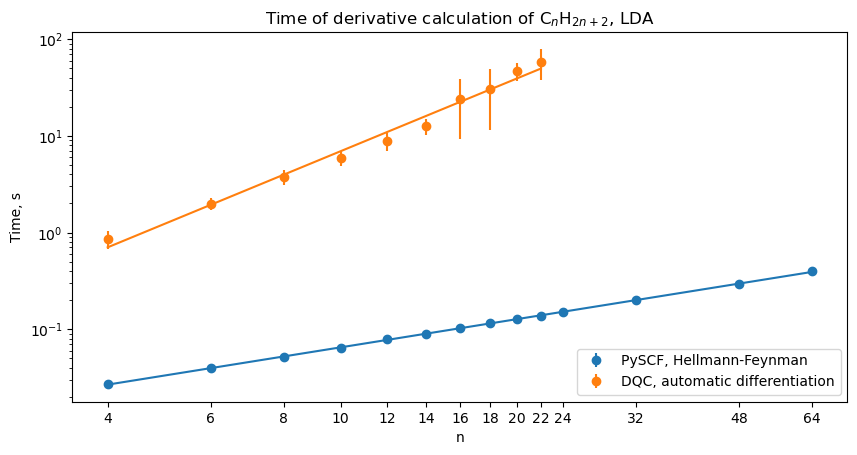

In [106]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

adjoint_x_alkanes = [l for l in alkanes_performance['pyscf_adjoint_lda'].keys() if alkanes_performance['pyscf_adjoint_lda'][l]]
adjoint_y_alkanes = [l["mean"] for l in alkanes_performance['pyscf_adjoint_lda'].values() if l]
adjoint_yerr_alkanes = [l["std_dev"] for l in alkanes_performance['pyscf_adjoint_lda'].values() if l]
adjoint_coeff_alkanes = numpy.polyfit(numpy.log(adjoint_x_alkanes), numpy.log(adjoint_y_alkanes), deg=1)
adjoint_poly_alkanes = numpy.poly1d(adjoint_coeff_alkanes)
adjoint_yfit_alkanes = [numpy.exp(adjoint_poly_alkanes(numpy.log(x))) for x in adjoint_x_alkanes]
ax.errorbar(adjoint_x_alkanes, adjoint_y_alkanes, yerr=adjoint_yerr_alkanes, 
            linestyle='None', marker='o', color='tab:blue', label='PySCF, Hellmann-Feynman')
ax.plot(adjoint_x_alkanes, adjoint_yfit_alkanes, linestyle='solid', color='tab:blue')


dqc_x_alkanes = [l for l in alkanes_performance['dqc_onlygrad_lda'].keys() if alkanes_performance['dqc_onlygrad_lda'][l]]
dqc_y_alkanes = [l["mean"] for l in alkanes_performance['dqc_onlygrad_lda'].values() if l]
dqc_yerr_alkanes = [l["std_dev"] for l in alkanes_performance['dqc_onlygrad_lda'].values() if l]
dqc_coeff_alkanes = numpy.polyfit(numpy.log(dqc_x_alkanes), numpy.log(dqc_y_alkanes), deg=1)
dqc_poly_alkanes = numpy.poly1d(dqc_coeff_alkanes)
dqc_yfit_alkanes = [numpy.exp(dqc_poly_alkanes(numpy.log(x))) for x in dqc_x_alkanes]
ax.errorbar(dqc_x_alkanes, dqc_y_alkanes, yerr=dqc_yerr_alkanes, 
            linestyle='None', marker='o', color='tab:orange', label='DQC, automatic differentiation')
ax.plot(dqc_x_alkanes, dqc_yfit_alkanes, linestyle='solid', color='tab:orange')

plt.xscale('log')
plt.yscale('log')

plt.title(r"Time of derivative calculation of C$_n$H$_{2n+2}$, LDA")
plt.xlabel("n")
plt.ylabel("Time, s")

ax.set_xticks(adjoint_x_alkanes)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_locator(ticker.NullLocator())

plt.legend(loc='lower right')

plt.savefig('figure_lda_3.png')

plt.show()

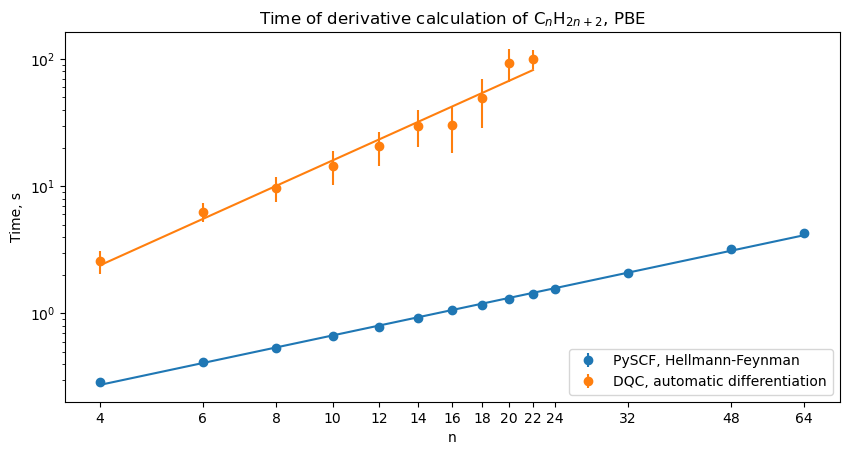

In [95]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

adjoint_x_alkanes = [l for l in alkanes_performance['pyscf_adjoint_pbe'].keys() if alkanes_performance['pyscf_adjoint_pbe'][l]]
adjoint_y_alkanes = [l["mean"] for l in alkanes_performance['pyscf_adjoint_pbe'].values() if l]
adjoint_yerr_alkanes = [l["std_dev"] for l in alkanes_performance['pyscf_adjoint_pbe'].values() if l]
adjoint_coeff_alkanes = numpy.polyfit(numpy.log(adjoint_x_alkanes), numpy.log(adjoint_y_alkanes), deg=1)
adjoint_poly_alkanes = numpy.poly1d(adjoint_coeff_alkanes)
adjoint_yfit_alkanes = [numpy.exp(adjoint_poly_alkanes(numpy.log(x))) for x in adjoint_x_alkanes]
ax.errorbar(adjoint_x_alkanes, adjoint_y_alkanes, yerr=adjoint_yerr_alkanes, 
            linestyle='None', marker='o', color='tab:blue', label='PySCF, Hellmann-Feynman')
ax.plot(adjoint_x_alkanes, adjoint_yfit_alkanes, linestyle='solid', color='tab:blue')

dqc_x_alkanes = [l for l in alkanes_performance['dqc_onlygrad_pbe'].keys() if alkanes_performance['dqc_onlygrad_pbe'][l]]
dqc_y_alkanes = [l["mean"] for l in alkanes_performance['dqc_onlygrad_pbe'].values() if l]
dqc_yerr_alkanes = [l["std_dev"] for l in alkanes_performance['dqc_onlygrad_pbe'].values() if l]
dqc_coeff_alkanes = numpy.polyfit(numpy.log(dqc_x_alkanes), numpy.log(dqc_y_alkanes), deg=1)
dqc_poly_alkanes = numpy.poly1d(dqc_coeff_alkanes)
dqc_yfit_alkanes = [numpy.exp(dqc_poly_alkanes(numpy.log(x))) for x in dqc_x_alkanes]
ax.errorbar(dqc_x_alkanes, dqc_y_alkanes, yerr=dqc_yerr_alkanes, 
            linestyle='None', marker='o', color='tab:orange', label='DQC, automatic differentiation')
ax.plot(dqc_x_alkanes, dqc_yfit_alkanes, linestyle='solid', color='tab:orange')

plt.xscale('log')
plt.yscale('log')

plt.title(r"Time of derivative calculation of C$_n$H$_{2n+2}$, PBE")
plt.xlabel("n")
plt.ylabel("Time, s")

ax.set_xticks(adjoint_x_alkanes)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_locator(ticker.NullLocator())

plt.legend(loc='lower right')

plt.savefig('figure_pbe_3.png')

plt.show()

### Density derivatives

The Hellmann-Feynman theorem holds only for variationally optimized energy. For other quantities, such as the electron density distribution, other methods must be used. Below we compare the accuracy of the automatic differentiation method and implicit differentiation one for the LDA and PBE functionals for the water molecule.

In [43]:
mol_name_ = "water"
aj_mol = molecules_for_correctness_tests[mol_name_]
analytic_partial_lda = AnalyticalPartialDerivativeCalculator(PySCFDataAdapter(PySCFLDAXConstructor, LDAX_default_parameters_dict, aj_mol))
analytic_partial_lda_dqc = AnalyticalPartialDerivativeCalculator(DQCDataAdapter(DQCLDAXConstructor, LDAX_default_parameters_dict, aj_mol))
rho_exact = PySCFAdapterCCSDT(aj_mol).construct_rho_on_grid(analytic_partial_lda.adapter.grid_coords)
rho_exact_dqc = PySCFAdapterCCSDT(aj_mol).construct_rho_on_grid(analytic_partial_lda_dqc.adapter.grid_coords)

In [44]:
iterative_total_lda = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCLDAXConstructor, 
                                                                                LDAX_default_parameters_dict, 
                                                                                aj_mol))

iterative_total_lda.construct_total_drho_squared_wrt_dtheta(rho_exact_dqc, retain_graph=True)
iterative_total_lda.total_drho_squared_wrt_dtheta

array([ 0.00688876, -0.02054143])

In [45]:
analytic_total_adjoint_lda = PartialToTotalDerivativeAdjoint(analytic_partial_lda)
analytic_total_adjoint_lda.construct_total_drho_squared_wrt_dtheta(rho_exact)
analytic_total_adjoint_lda.total_drho_squared_wrt_dtheta

started the four term integral computation for 34310...


array([ 0.00688652, -0.02053853])

In [46]:
def density_getter(a, rho_exact):
    a.construct_rho_squared(rho_exact)
    return a.rho_squared

drho_fd, _, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterAuto,
                                                          PySCFLDAXConstructor,
                                                          LDAX_default_parameters_dict,
                                                          lambda a: density_getter(a, rho_exact),
                                                          aj_mol)
drho_fd = drho_fd
print(f"For {mol_name_}:")
print(f"drho/dtheta = {drho_fd}")

For water:
drho/dtheta = [ 0.00688512 -0.02052864]


In [47]:
iterative_total_pbe = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCPBEConstructor, 
                                                                                PBE_default_parameters_dict, 
                                                                                aj_mol))

iterative_total_pbe.construct_total_drho_squared_wrt_dtheta(rho_exact_dqc, retain_graph=True)
iterative_total_pbe.total_drho_squared_wrt_dtheta

array([-7.69513197e-03,  9.24275044e-03, -1.21229734e-03, -2.76373012e-03,
       -9.29343644e-05,  9.19616614e-04,  5.69091737e-03, -2.72468659e-04,
       -1.70749409e-05,  1.55159955e-06,  1.89934622e-05,  3.70781820e-05])

In [48]:
mixed_partial_pbe = MixedPartialDerivativeCalculator(PySCFDataAdapter(PySCFPBEConstructor, PBE_default_parameters_dict, aj_mol))
mixed_total_adjoint_pbe = PartialToTotalDerivativeAdjoint(mixed_partial_pbe)
mixed_total_adjoint_pbe.construct_total_drho_squared_wrt_dtheta(rho_exact)
mixed_total_adjoint_pbe.total_drho_squared_wrt_dtheta

array([-7.69741939e-03,  9.24589216e-03, -1.21281155e-03, -2.76507367e-03,
       -9.30082072e-05,  9.19787589e-04,  5.69295304e-03, -2.72516071e-04,
       -1.70816331e-05,  1.55043435e-06,  1.89969747e-05,  3.70859055e-05])

In [49]:
drho_fd, _, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterAuto,
                                                          PySCFPBEConstructor,
                                                          PBE_default_parameters_dict,
                                                          lambda a: density_getter(a, rho_exact),
                                                          aj_mol)
drho_fd = drho_fd
print(f"For {mol_name_}:")
print(f"drho/dtheta = {drho_fd}")

For water:
drho/dtheta = [-7.69882077e-03  9.25611484e-03 -1.21288306e-03 -2.76512278e-03
 -9.30228920e-05  9.19819685e-04  5.69295189e-03 -2.72498452e-04
 -1.70816189e-05  1.54991538e-06  1.89958262e-05  3.70835777e-05]


### Dependence of derivatives on the basis set

In [50]:
basis_names = ["cc-pVDZ", "cc-pVTZ", "cc-pVQZ", "cc-pV5Z"]

for mol_name in ["h2", "water"]:
    print(f"For molecule {mol_name}:")
    aj_mol = molecules_for_correctness_tests[mol_name]
    for basis_name in basis_names:
        if (mol_name == "water" and basis_name == "cc-pV5Z"):
            continue
        print(f"For {basis_name}:")    
        analytic_partial = AnalyticalPartialDerivativeCalculator(PySCFDataAdapter(PySCFLDAXConstructor, LDAX_default_parameters_dict, aj_mol, basis=basis_name))
        
        hellmann_feynman = HellmannFeynmanTotalDerivative(analytic_partial)
        hellmann_feynman.construct_total_dE_wrt_dtheta()
        print(f"dE/dtheta, Hellmann-Feynman = {hellmann_feynman.total_dE_wrt_dtheta}")

        analytic_total_adjoint = PartialToTotalDerivativeAdjoint(analytic_partial)
        analytic_total_adjoint.construct_total_dE_wrt_dtheta()
        print(f"Δ(dE/dtheta), analytic = {analytic_total_adjoint.total_dE_wrt_dtheta - hellmann_feynman.total_dE_wrt_dtheta}")
        
        der, _, _ = FiniteDifferenceTotalDerivativeCalculator(PySCFAdapterCustom,
                                                   PySCFLDAXConstructor,
                                                   LDAX_default_parameters_dict,
                                                   lambda a: a.total_energy,
                                                   aj_mol,
                                                   basis=basis_name)
        print(f"Δ(dE/dtheta), FD = {der - hellmann_feynman.total_dE_wrt_dtheta}")
        
        iterative_total = IterativeAutogradTotalDerivativeCalculator(DQCAdapterWithgrad(DQCLDAXConstructor,
                                                   LDAX_default_parameters_dict, aj_mol, basis=basis_name))
        iterative_total.construct_total_dE_wrt_dtheta()
        print(f"Δ(dE/dtheta), AD = {iterative_total.total_dE_wrt_dtheta - hellmann_feynman.total_dE_wrt_dtheta}")

For molecule h2:
For cc-pVDZ:
dE/dtheta, Hellmann-Feynman = [0.74829134 1.47555614]
started the four term integral computation for 20048...
Δ(dE/dtheta), analytic = [7.31636973e-14 4.15889545e-13]
Δ(dE/dtheta), FD = [ 5.84862286e-07 -3.12686778e-05]
Δ(dE/dtheta), AD = [-1.23801119e-06 -1.21011720e-06]
For cc-pVTZ:
dE/dtheta, Hellmann-Feynman = [0.74660888 1.4610596 ]
started the four term integral computation for 20048...
Δ(dE/dtheta), analytic = [8.27116153e-14 4.76951811e-13]
Δ(dE/dtheta), FD = [ 6.40289452e-07 -3.14948752e-05]
Δ(dE/dtheta), AD = [-1.28817092e-06 -1.22650078e-06]
For cc-pVQZ:
dE/dtheta, Hellmann-Feynman = [0.74648306 1.46114144]
started the four term integral computation for 20048...
Δ(dE/dtheta), analytic = [8.38218384e-14 5.08260101e-13]
Δ(dE/dtheta), FD = [ 6.39311672e-07 -3.15497458e-05]
Δ(dE/dtheta), AD = [-1.20529197e-06 -1.18085394e-06]
For cc-pV5Z:
dE/dtheta, Hellmann-Feynman = [0.74641917 1.46091701]
started the four term integral computation for 20048...
Δ(